<a href="https://colab.research.google.com/github/HenryLimaa/Jobs/blob/main/DesafioPPAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Instalação das bibliotecas

!pip install earthengine-api
!pip install geemap tensorflow rasterio matplotlib scikit-learn numpy ipywidgets
!pip install segmentation_models_pytorch > /dev/null
!pip install sentinelhub > /dev/null
!pip install geopandas > /dev/null
!pip install shapely > /dev/null
!pip install scikit-image > /dev/null
!pip install --upgrade ipywidgets > /dev/null
!pip install folium > /dev/null
!pip install --upgrade pip > /dev/null
!pip install ipywidgets[widgetsnbextension] > /dev/null
!pip install --upgrade ipywidgets > /dev/null

In [2]:
# @title 1. CONFIGURAÇÃO INICIAL E AUTENTICAÇÃO


# EARTH ENGINE & GEOESPACIAIS
import ee
import geemap
import folium

# DEEP LEARNING & IA
import tensorflow as tf
from tensorflow.keras import layers, models

# PROCESSAMENTO DE IMAGENS E DADOS GEOESPACIAIS
import numpy as np
import cv2
import rasterio
from rasterio.transform import from_origin

# VISUALIZAÇÃO E INTERFACE
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# PRÉ-PROCESSAMENTO & VALIDAÇÃO
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# MANIPULAÇÃO DE ARQUIVOS & DOWNLOAD
import requests
import zipfile
import os
from io import BytesIO

# UTILITÁRIOS E TEMPORAIS
import datetime

# Inicializar Earth Engine
try:
    project_id = input("Digite o ID do seu projeto Earth Engine") # Exemplo: my-earth-engine-project-472319
    ee.Initialize(project=project_id)
except Exception as e:
    print(f"Erro ao inicializar Earth Engine: {e}")
    print("Tentando autenticar...")
    ee.Authenticate()
    project_id = input("Digite o ID do seu projeto Earth Engine após a autenticação: ")
    ee.Initialize(project=project_id)


print("Bibliotecas carregadas e Earth Engine inicializado!")

Digite o ID do seu projeto Earth Enginemy-earth-engine-project-472319
Bibliotecas carregadas e Earth Engine inicializado!


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [3]:
# @title 2. CONFIGURAÇÕES ESPECÍFICAS PARA ALTAMIRA/PA

# Coordenadas do Aeroporto de Altamira/PA
ALTAMIRA_COORDS = [-52.2540, -3.2535]  # [longitude, latitude]
REGIAO_AEROPORTO = ee.Geometry.Point(ALTAMIRA_COORDS).buffer(10000)  # 10km ao redor

In [4]:
# @title 3. FUNÇÕES ESPECÍFICAS PARA DETECÇÃO DE PISTAS

def baixar_imagem_aeroporto_altamira(data_inicio='2023-01-01', data_fim='2023-12-31', nuvens=5):
    """
    Baixa imagem de alta resolução da região do aeroporto de Altamira
    """
    # Filtrar imagens Sentinel-2 com poucas nuvens
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(REGIAO_AEROPORTO) \
        .filterDate(data_inicio, data_fim) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', nuvens)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first()

    # Bandas para detecção de infraestrutura (RGB + NIR)
    imagem_completa = sentinel2.select(['B4', 'B3', 'B2', 'B8'])  # Red, Green, Blue, NIR

    # Aplicar realce para melhor visualização
    imagem_realcada = imagem_completa.visualize(**{
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 3000,
        'gamma': 1.4
    })

    # Download da imagem
    nome_arquivo = f"altamira_aeroporto_{data_inicio}_{data_fim}.tif"
    geemap.ee_export_image(
        imagem_realcada,
        filename=nome_arquivo,
        scale=10,
        region=REGIAO_AEROPORTO.bounds(),
        file_per_band=False
    )

    return nome_arquivo, imagem_completa

def detectar_pistas_por_ndvi(imagem_ee):
    """
    Usa NDVI para detectar áreas pavimentadas (pistas de pouso)
    """
    # Calcular NDVI
    ndvi = imagem_ee.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Áreas pavimentadas geralmente têm NDVI baixo
    areas_pavimentadas = ndvi.lt(0.2)  # Threshold para áreas não-vegetadas

    return areas_pavimentadas, ndvi

def detectar_linhas_retas(imagem_cv):
    """
    Detecta linhas retas características de pistas usando Hough Lines
    """
    # Converter para escala de cinza
    gray = cv2.cvtColor(imagem_cv, cv2.COLOR_RGB2GRAY)

    # Aplicar detecção de bordas
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Detectar linhas com Hough Lines
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=50,
        minLineLength=100,
        maxLineGap=10
    )

    return lines, edges

def criar_modelo_deteccao_pistas():
    """
    Cria modelo CNN para detecção de pistas de pouso
    """
    modelo = models.Sequential([
        # Camada de entrada
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),

        # Camadas intermediárias
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Camadas fully connected
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binária: pista ou não-pista
    ])

    modelo.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return modelo

In [5]:
# @title 4. ANÁLISE ESPECIALIZADA PARA PISTAS DE AEROPORTO

def analisar_pistas_altamira():
    """
    Análise completa das pistas do aeroporto de Altamira
    """
    print("Iniciando análise do Aeroporto de Altamira/PA")
    print("=" * 60)

    # 1. Baixar imagem mais recente
    print("Baixando imagem Sentinel-2...")
    arquivo_imagem, imagem_ee = baixar_imagem_aeroporto_altamira()
    print(f"Imagem baixada: {arquivo_imagem}")

    # 2. Detectar áreas pavimentadas com NDVI
    print("Detectando áreas pavimentadas...")
    areas_pavimentadas, ndvi = detectar_pistas_por_ndvi(imagem_ee)

    # 3. Processar imagem para análise visual
    imagem_cv = cv2.imread(arquivo_imagem)
    imagem_cv = cv2.cvtColor(imagem_cv, cv2.COLOR_BGR2RGB)

    # 4. Detectar linhas retas (pistas)
    print("Detectando linhas retas...")
    linhas, bordas = detectar_linhas_retas(imagem_cv)

    # 5. Calcular métricas
    area_total = REGIAO_AEROPORTO.area().getInfo()  # m²
    print(f" Área total analisada: {area_total:,.0f} m²")

    # 6. Visualizar resultados
    visualizar_resultados_altamira(imagem_cv, linhas, bordas, arquivo_imagem)

    return {
        'arquivo_imagem': arquivo_imagem,
        'areas_pavimentadas': areas_pavimentadas,
        'ndvi': ndvi,
        'linhas_detectadas': linhas,
        'imagem_processada': imagem_cv
    }

def visualizar_resultados_altamira(imagem, linhas, bordas, arquivo_imagem):
    """
    Visualização completa dos resultados
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Imagem original
    axes[0,0].imshow(imagem)
    axes[0,0].set_title('Imagem Original - Aeroporto de Altamira')
    axes[0,0].axis('off')

    # Detecção de bordas
    axes[0,1].imshow(bordas, cmap='gray')
    axes[0,1].set_title('Detecção de Bordas')
    axes[0,1].axis('off')

    # Linhas detectadas
    imagem_linhas = imagem.copy()
    if linhas is not None:
        for line in linhas:
            x1, y1, x2, y2 = line[0]
            cv2.line(imagem_linhas, (x1, y1), (x2, y2), (255, 0, 0), 3)

    axes[1,0].imshow(imagem_linhas)
    axes[1,0].set_title(f'Linhas Detectadas: {len(linhas) if linhas is not None else 0}')
    axes[1,0].axis('off')

    # Histograma de cores para análise de materiais
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        histogram = cv2.calcHist([imagem], [i], None, [256], [0, 256])
        axes[1,1].plot(histogram, color=color)
    axes[1,1].set_title('Histograma de Cores')
    axes[1,1].set_xlabel('Intensidade')
    axes[1,1].set_ylabel('Frequência')

    plt.tight_layout()
    plt.savefig('analise_altamira_resultados.png', dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
# @title 5. INTERFACE ESPECIALIZADA PARA AEROPORTOS

def criar_interface_altamira():
    """
    Interface específica para análise do aeroporto de Altamira
    """
    # Widgets específicos para análise aeroportuária
    data_inicio = widgets.DatePicker(
        description='Data Início:',
        value=datetime.date(2023, 1, 1)
    )
    data_fim = widgets.DatePicker(
        description='Data Fim:',
        value=datetime.date(2023, 12, 31)
    )

    limite_nuvens = widgets.IntSlider(
        description='Limite de Nuvens (%):',
        min=0,
        max=20,
        value=5,
        step=1
    )

    botao_analisar = widgets.Button(
        description='Analisar Pistas de Altamira',
        button_style='success',
        icon='search'
    )

    output = widgets.Output()

    def analisar_com_callback(b):
        with output:
            output.clear_output()
            print("Iniciando análise especializada...")
            resultados = analisar_pistas_altamira()
            print("Análise concluída!")

            # Exibir informações específicas
            if resultados['linhas_detectadas'] is not None:
                print(f"Número de linhas detectadas: {len(resultados['linhas_detectadas'])}")

            # Criar mapa interativo
            criar_mapa_altamira_interativo()

    botao_analisar.on_click(analisar_com_callback)

    # Layout organizado
    interface = widgets.VBox([
        widgets.HTML("<h2>Análise de Pistas - Aeroporto de Altamira/PA</h2>"),
        widgets.HBox([data_inicio, data_fim]),
        limite_nuvens,
        botao_analisar,
        output
    ])

    return interface

def criar_mapa_altamira_interativo():
    """
    Mapa interativo focado no aeroporto de Altamira
    """
    # Criar mapa centrado no aeroporto
    mapa = folium.Map(
        location=[-3.2535, -52.2540],
        zoom_start=14,
        tiles='OpenStreetMap'
    )

    # Adicionar marcador do aeroporto
    folium.Marker(
        [-3.2535, -52.2540],
        popup='Aeroporto de Altamira/PA',
        tooltip='Aeroporto Internacional de Altamira',
        icon=folium.Icon(color='red', icon='plane')
    ).add_to(mapa)

    # Adicionar círculo da área de análise
    folium.Circle(
        radius=5000,  # 5km
        location=[-3.2535, -52.2540],
        popup='Área de Análise (5km)',
        color='red',
        fill=False
    ).add_to(mapa)

    # Adicionar camada do Google Satellite
    folium.TileLayer(
        tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr='Google Satellite',
        name='Google Satellite'
    ).add_to(mapa)

    folium.LayerControl().add_to(mapa)

    display(mapa)

    return mapa

In [7]:
# @title 6. RELATÓRIO DE ANÁLISE

def gerar_relatorio_altamira(resultados):
    """
    Gera relatório detalhado da análise
    """
    print("\n" + "="*60)
    print(" RELATÓRIO - AEROPORTO DE ALTAMIRA/PA")
    print("="*60)

    # Informações básicas
    print(f" Localização: Altamira/Pará")
    print(f"  Data da análise: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}")
    print(f" Coordenadas aeroporto: -3.2535°S, -52.2540°W")

    # Métricas detectadas
    if resultados['linhas_detectadas'] is not None:
        print(f" Linhas retas detectadas: {len(resultados['linhas_detectadas'])}")

        # Estimar comprimento médio das linhas (aproximado)
        comprimentos = []
        for linha in resultados['linhas_detectadas']:
            x1, y1, x2, y2 = linha[0]
            comprimento = np.sqrt((x2-x1)**2 + (y2-y1)**2)
            comprimentos.append(comprimento)

        if comprimentos:
            print(f"Comprimento médio das linhas: {np.mean(comprimentos):.1f} pixels")

    print("\n RECOMENDAÇÕES:")
    print("• Verificar alinhamento das pistas detectadas")
    print("• Comparar com dados oficiais do aeroporto")
    print("• Monitorar mudanças na infraestrutura ao longo do tempo")


In [8]:
# @title 7. FUNÇÃO PRINCIPAL ESPECIALIZADA

def main_altamira():
    """
    Função principal especializada para análise do aeroporto de Altamira
    """
    print(" SISTEMA DE ANÁLISE DE PISTAS - AEROPORTO DE ALTAMIRA/PA")
    print("=" * 70)

    # Exibir informações do projeto Earth Engine

    print(" Foco: Aeroporto Internacional de Altamira/PA")
    print(" Objetivo: Detecção e análise de pistas de pouso")

    # Criar interface especializada
    print("\n  Carregando interface...")
    interface = criar_interface_altamira()
    display(interface)

    # Executar análise inicial automática
    print("\n Executando análise inicial...")
    try:
        resultados = analisar_pistas_altamira()
        gerar_relatorio_altamira(resultados)
    except Exception as e:
        print(f"  Análise inicial não pôde ser concluída: {e}")
        print("Use a interface acima para configurar os parâmetros manualmente")

 SISTEMA DE ANÁLISE DE PISTAS - AEROPORTO DE ALTAMIRA/PA
 Foco: Aeroporto Internacional de Altamira/PA
 Objetivo: Detecção e análise de pistas de pouso

  Carregando interface...



 Executando análise inicial...
Iniciando análise do Aeroporto de Altamira/PA
Baixando imagem Sentinel-2...
Generating URL ...


/usr/local/lib/python3.12/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Please wait ...
Data downloaded to /content/altamira_aeroporto_2023-01-01_2023-12-31.tif
Imagem baixada: altamira_aeroporto_2023-01-01_2023-12-31.tif
Detectando áreas pavimentadas...
Detectando linhas retas...
 Área total analisada: 310,406,007 m²


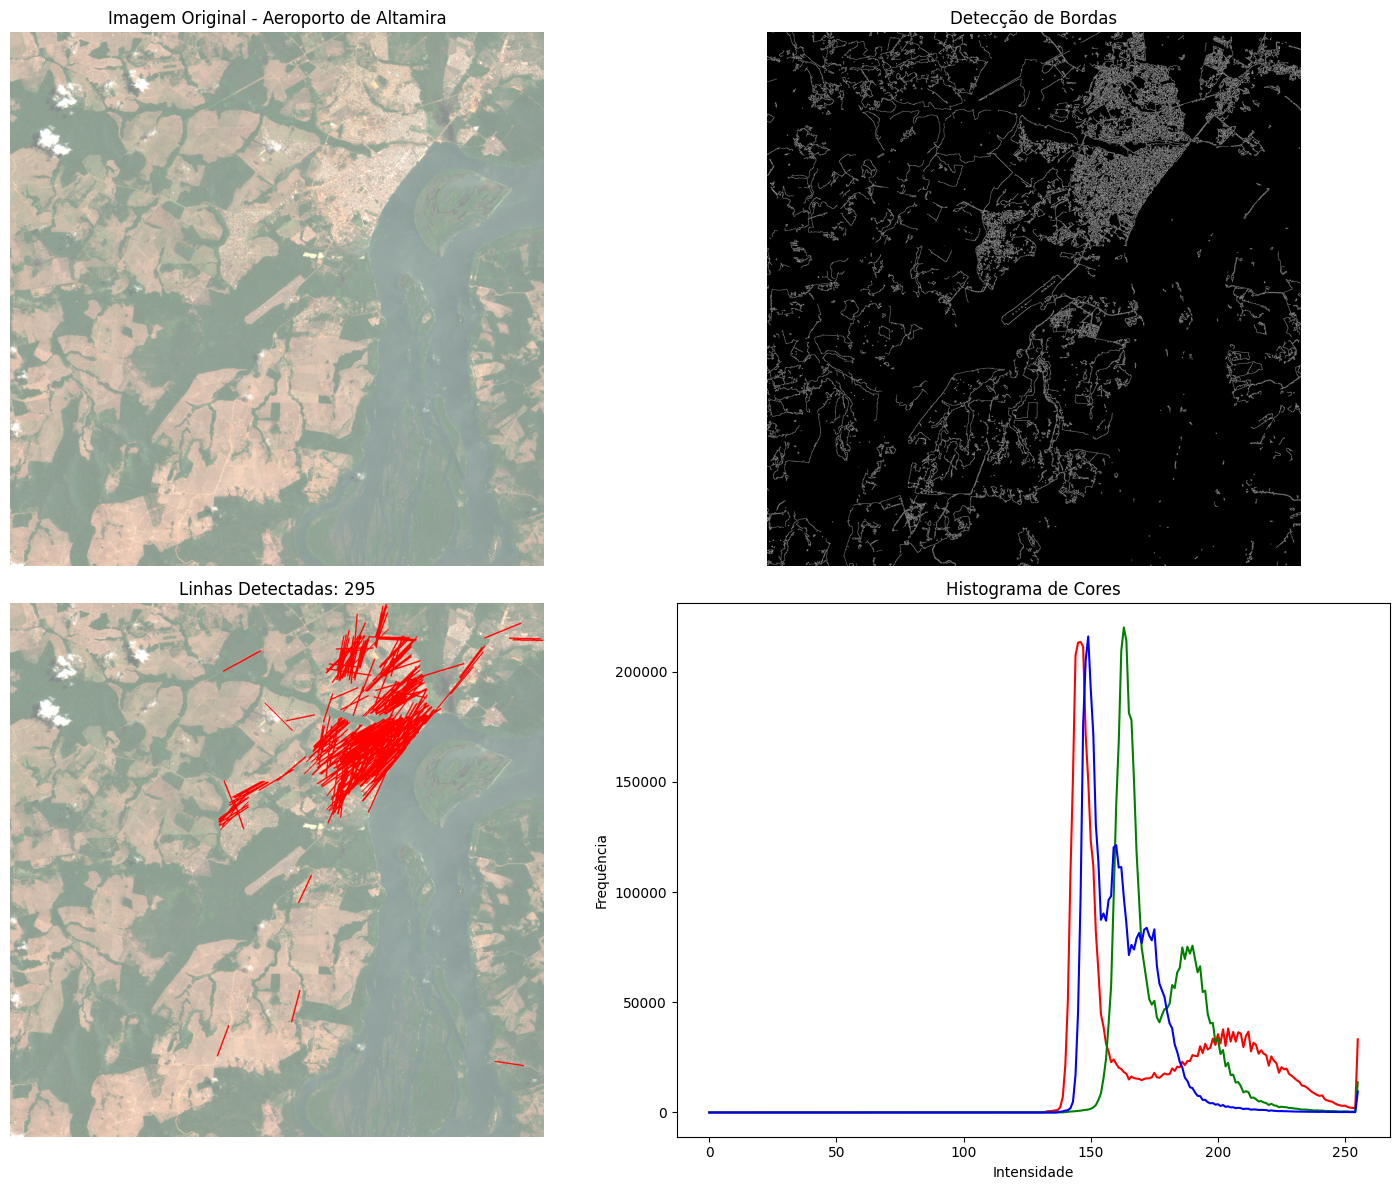


 RELATÓRIO - AEROPORTO DE ALTAMIRA/PA
 Localização: Altamira/Pará
  Data da análise: 2025-09-26 07:02
 Coordenadas aeroporto: -3.2535°S, -52.2540°W
 Linhas retas detectadas: 295
Comprimento médio das linhas: 177.0 pixels

 RECOMENDAÇÕES:
• Verificar alinhamento das pistas detectadas
• Comparar com dados oficiais do aeroporto
• Monitorar mudanças na infraestrutura ao longo do tempo

FUNÇÕES AVANÇADAS DISPONÍVEIS

    Funções disponíveis:

    1. baixar_imagem_aeroporto_altamira() - Download de imagens atualizadas
    2. detectar_pistas_por_ndvi() - Detecção por índice de vegetação
    3. detectar_linhas_retas() - Detecção de pistas por linhas retas
    4. criar_modelo_deteccao_pistas() - Modelo de IA para classificação
    5. analisar_pistas_altamira() - Análise completa
    6. criar_interface_altamira() - Interface interativa
    


In [9]:
# @title 8. EXECUÇÃO

if __name__ == "__main__":
    # Executar análise especializada
    main_altamira()

    # Exemplo de uso avançado
    print("\n" + "="*70)
    print("FUNÇÕES AVANÇADAS DISPONÍVEIS")
    print("="*70)

    print("""
    Funções disponíveis:

    1. baixar_imagem_aeroporto_altamira() - Download de imagens atualizadas
    2. detectar_pistas_por_ndvi() - Detecção por índice de vegetação
    3. detectar_linhas_retas() - Detecção de pistas por linhas retas
    4. criar_modelo_deteccao_pistas() - Modelo de IA para classificação
    5. analisar_pistas_altamira() - Análise completa
    6. criar_interface_altamira() - Interface interativa
    """)

In [10]:
# @title FUNÇÕES AVANÇADAS PARA DETECÇÃO DE PISTAS

def detectar_pistas_por_ndvi(imagem_ee, threshold=0.2, area_minima=1000):
    """
    Detecção avançada de pistas usando NDVI com análise de forma e tamanho

    Args:
        imagem_ee: Imagem Earth Engine
        threshold: Limite NDVI para áreas pavimentadas (0-1)
        area_minima: Área mínima em m² para considerar como pista

    Returns:
        Dict com resultados detalhados da análise
    """
    print("🌱 Iniciando detecção por NDVI...")

    try:
        # Calcular NDVI
        ndvi = imagem_ee.normalizedDifference(['B8', 'B4']).rename('NDVI')

        # Criar máscara de áreas pavimentadas (bajo NDVI)
        areas_pavimentadas = ndvi.lt(threshold)

        # Aplicar operações morfológicas para limpieza
        kernel = ee.Kernel.circle(radius=3)
        areas_fechadas = areas_pavimentadas.focal_max(kernel=kernel, iterations=2)
        areas_limpas = areas_fechadas.focal_min(kernel=kernel, iterations=1)

        # Encontrar contornos e calcular propriedades
        connected_components = areas_limpas.connectedComponents(
            connectedness=ee.Kernel.plus(1),
            maxSize=128
        )

        # Filtrar por área mínima
        areas_filtradas = connected_components.select('labels')

        # Calcular estatísticas
        stats = areas_limpas.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=REGIAO_AEROPORTO,
            scale=10,
            maxPixels=1e9
        )

        # Extrair features geométricas das áreas detectadas
        features = areas_limpas.reduceToVectors(
            geometry=REGIAO_AEROPORTO,
            scale=10,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='pista',
            maxPixels=1e9
        )

        # Filtrar features por área
        features_filtradas = features.filter(ee.Filter.gte('area', area_minima))

        print(f"✅ NDVI calculado. Áreas detectadas: {features_filtradas.size().getInfo()}")

        return {
            'ndvi_image': ndvi,
            'areas_pavimentadas': areas_limpas,
            'features': features_filtradas,
            'estatisticas': stats,
            'threshold': threshold
        }

    except Exception as e:
        print(f"❌ Erro na detecção por NDVI: {e}")
        return None

In [11]:
def detectar_pistas_por_ndvi(imagem_ee):
    """
    Usa NDVI para detectar áreas pavimentadas (pistas de pouso)
    """
    # Calcular NDVI
    ndvi = imagem_ee.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Áreas pavimentadas geralmente têm NDVI baixo
    areas_pavimentadas = ndvi.lt(0.2)  # Threshold para áreas não-vegetadas

    return areas_pavimentadas, ndvi

def analisar_pistas_altamira():
    """
    Análise completa das pistas do aeroporto de Altamira
    """
    print("Iniciando análise do Aeroporto de Altamira/PA")
    print("=" * 60)

    # 1. Baixar imagem mais recente
    print("Baixando imagem Sentinel-2...")
    arquivo_imagem, imagem_ee = baixar_imagem_aeroporto_altamira()
    print(f"Imagem baixada: {arquivo_imagem}")

    # 2. Detectar áreas pavimentadas com NDVI
    print("Detectando áreas pavimentadas...")
    areas_pavimentadas, ndvi = detectar_pistas_por_ndvi(imagem_ee)

    # 3. Processar imagem para análise visual
    imagem_cv = cv2.imread(arquivo_imagem)
    imagem_cv = cv2.cvtColor(imagem_cv, cv2.COLOR_BGR2RGB)

    # 4. Detectar linhas retas (pistas)
    print("Detectando linhas retas...")
    linhas, bordas = detectar_linhas_retas(imagem_cv)

    # 5. Calcular métricas
    area_total = REGIAO_AEROPORTO.area().getInfo()  # m²
    print(f" Área total analisada: {area_total:,.0f} m²")

    # 6. Visualizar resultados
    visualizar_resultados_altamira(imagem_cv, linhas, bordas, arquivo_imagem)

    return {
        'arquivo_imagem': arquivo_imagem,
        'areas_pavimentadas': areas_pavimentadas,
        'ndvi': ndvi,
        'linhas_detectadas': linhas,
        'imagem_processada': imagem_cv
    }

In [12]:
def detectar_pistas_por_ndvi_avancado(imagem_ee, threshold=0.2, area_minima=1000):
    """
    Detecção avançada de pistas usando NDVI com análise de forma e tamanho

    Args:
        imagem_ee: Imagem Earth Engine
        threshold: Limite NDVI para áreas pavimentadas (0-1)
        area_minima: Área mínima em m² para considerar como pista

    Returns:
        Dict com resultados detalhados da análise
    """
    print("🌱 Iniciando detecção por NDVI...")

    try:
        # Calcular NDVI
        ndvi = imagem_ee.normalizedDifference(['B8', 'B4']).rename('NDVI')

        # Criar máscara de áreas pavimentadas (bajo NDVI)
        areas_pavimentadas = ndvi.lt(threshold)

        # Aplicar operações morfológicas para limpieza
        kernel = ee.Kernel.circle(radius=3)
        areas_fechadas = areas_pavimentadas.focal_max(kernel=kernel, iterations=2)
        areas_limpas = areas_fechadas.focal_min(kernel=kernel, iterations=1)

        # Encontrar contornos e calcular propriedades
        connected_components = areas_limpas.connectedComponents(
            connectedness=ee.Kernel.plus(1),
            maxSize=128
        )

        # Filtrar por área mínima
        areas_filtradas = connected_components.select('labels')

        # Calcular estatísticas
        stats = areas_limpas.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=REGIAO_AEROPORTO,
            scale=10,
            maxPixels=1e9
        )

        # Extrair features geométricas das áreas detectadas
        features = areas_limpas.reduceToVectors(
            geometry=REGIAO_AEROPORTO,
            scale=10,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='pista',
            maxPixels=1e9
        )

        # Filtrar features por área
        features_filtradas = features.filter(ee.Filter.gte('area', area_minima))

        print(f"✅ NDVI calculado. Áreas detectadas: {features_filtradas.size().getInfo()}")

        return {
            'ndvi_image': ndvi,
            'areas_pavimentadas': areas_limpas,
            'features': features_filtradas,
            'estatisticas': stats,
            'threshold': threshold
        }

    except Exception as e:
        print(f"❌ Erro na detecção por NDVI: {e}")
        return None

def detectar_linhas_retas_avancado(imagem_cv, parametros=None):
    """
    Detecção avançada de linhas retas com múltiplos algoritmos e análise de orientação

    Args:
        imagem_cv: Imagem OpenCV
        parametros: Dicionário com parâmetros personalizados

    Returns:
        Dict com resultados detalhados da detecção
    """
    print("📏 Iniciando detecção de linhas retas...")

    if parametros is None:
        parametros = {
            'canny_threshold1': 50,
            'canny_threshold2': 150,
            'hough_threshold': 30,
            'min_line_length': 50,
            'max_line_gap': 20,
            'rho_resolution': 1,
            'theta_resolution': np.pi/180
        }

    try:
        # Pré-processamento avançado
        if len(imagem_cv.shape) == 3:
            gray = cv2.cvtColor(imagem_cv, cv2.COLOR_BGR2GRAY)
        else:
            gray = imagem_cv

        # Aplicar filtro Gaussiano para redução de ruído
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Equalização de histograma para melhor contraste
        equalized = cv2.equalizeHist(blurred)

        # Detecção de bordas com Canny
        edges = cv2.Canny(equalized,
                         parametros['canny_threshold1'],
                         parametros['canny_threshold2'])

        # Detecção de linhas com HoughLinesP
        lines_p = cv2.HoughLinesP(
            edges,
            rho=parametros['rho_resolution'],
            theta=parametros['theta_resolution'],
            threshold=parametros['hough_threshold'],
            minLineLength=parametros['min_line_length'],
            maxLineGap=parametros['max_line_gap']
        )

        # Detecção alternativa com HoughLines tradicional
        lines_trad = cv2.HoughLines(
            edges,
            rho=parametros['rho_resolution'],
            theta=parametros['theta_resolution'],
            threshold=parametros['hough_threshold']
        )

        # Análise das linhas detectadas
        analise_linhas = analisar_linhas_detectadas(lines_p, lines_trad, imagem_cv.shape)

        # Filtrar linhas por orientação (pistas geralmente têm orientação específica)
        linhas_filtradas = filtrar_linhas_por_orientacao(lines_p, analise_linhas['orientacao_media'])

        print(f"✅ Linhas detectadas - HoughP: {len(lines_p) if lines_p is not None else 0}, "
              f"Tradicional: {len(lines_trad) if lines_trad is not None else 0}")

        return {
            'imagem_original': imagem_cv,
            'edges': edges,
            'lines_houghp': lines_p,
            'lines_tradicional': lines_trad,
            'linhas_filtradas': linhas_filtradas,
            'analise': analise_linhas,
            'parametros': parametros
        }

    except Exception as e:
        print(f"❌ Erro na detecção de linhas: {e}")
        return None

def criar_modelo_deteccao_pistas_avancado(input_shape=(256, 256, 3), num_classes=3):
    """
    Cria modelo avançado de CNN para classificação de pistas de aeroporto

    Args:
        input_shape: Dimensões da imagem de entrada
        num_classes: Número de classes (pista, nao_pista, incerto)

    Returns:
        Modelo Keras compilado
    """
    print("🧠 Criando modelo avançado de detecção de pistas...")

    try:
        # Entrada
        inputs = tf.keras.Input(shape=input_shape)

        # Camada de pré-processamento
        x = layers.Rescaling(1./255)(inputs)

        # Bloco 1
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Bloco 2
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Bloco 3
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Bloco 4
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)

        # Camadas fully connected
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        # Saída
        if num_classes == 2:
            outputs = layers.Dense(1, activation='sigmoid', name='classification')(x)
            loss = 'binary_crossentropy'
        else:
            outputs = layers.Dense(num_classes, activation='softmax', name='classification')(x)
            loss = 'sparse_categorical_crossentropy'

        modelo = tf.keras.Model(inputs=inputs, outputs=outputs)

        # Compilar modelo
        modelo.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss,
            metrics=['accuracy', 'precision', 'recall']
        )

        print("✅ Modelo criado com sucesso!")
        print(f"📊 Arquitetura: {modelo.count_params():,} parâmetros treináveis")

        return modelo

    except Exception as e:
        print(f"❌ Erro na criação do modelo: {e}")
        return None

def analisar_pistas_altamira_avancado(data_inicio='2023-01-01', data_fim='2023-12-31', usar_ia=True):
    """
    Análise avançada e completa das pistas do aeroporto de Altamira
    Integra múltiplas técnicas de detecção
    """
    print("🛫 INICIANDO ANÁLISE AVANÇADA DE PISTAS")
    print("=" * 70)

    # 1. Baixar e preparar dados
    print("📥 Fase 1: Aquisição de dados...")
    # Assuming baixar_imagem_aeroporto_altamira is the original function
    arquivo_imagem, imagem_ee = baixar_imagem_aeroporto_altamira(
        data_inicio=data_inicio,
        data_fim=data_fim,
        escala=20
    )

    if not arquivo_imagem:
        print("❌ Falha na aquisição de dados")
        return None

    # Assuming carregar_imagem_segura exists elsewhere or needs definition
    def carregar_imagem_segura(arquivo_imagem):
        try:
            img = cv2.imread(arquivo_imagem)
            if img is None:
                print(f"Erro: Não foi possível carregar a imagem {arquivo_imagem}")
                return None
            return img
        except Exception as e:
            print(f"Erro ao carregar imagem {arquivo_imagem}: {e}")
            return None

    imagem_cv = carregar_imagem_segura(arquivo_imagem)
    if imagem_cv is None:
        return None

    resultados = {
        'metadata': {
            'data_analise': datetime.datetime.now().isoformat(),
            'arquivo_imagem': arquivo_imagem,
            'periodo_analise': f"{data_inicio} a {data_fim}",
            'usar_ia': usar_ia
        },
        'tecnicas': {}
    }

    # 2. Análise por NDVI
    print("🌱 Fase 2: Análise por NDVI...")
    resultado_ndvi = detectar_pistas_por_ndvi_avancado(imagem_ee)
    resultados['tecnicas']['ndvi'] = resultado_ndvi

    # 3. Detecção de linhas retas
    print("📏 Fase 3: Detecção de linhas retas...")
    resultado_linhas = detectar_linhas_retas_avancado(imagem_cv)
    resultados['tecnicas']['linhas_retas'] = resultado_linhas

    # 4. Análise com IA (opcional)
    if usar_ia:
        print("🧠 Fase 4: Análise com inteligência artificial...")
        resultado_ia = executar_analise_ia(imagem_cv)
        resultados['tecnicas']['ia'] = resultado_ia

    # 5. Integração dos resultados
    print("🔗 Fase 5: Integração dos resultados...")
    resultados_integrados = integrar_resultados(resultados)
    resultados['resultado_final'] = resultados_integrados

    # 6. Gerar relatório completo
    print("📊 Fase 6: Gerando relatório...")
    relatorio = gerar_relatorio_avancado(resultados)
    resultados['relatorio'] = relatorio

    # 7. Visualização avançada
    print("🎨 Fase 7: Visualização dos resultados...")
    visualizar_resultados_avancados(resultados, imagem_cv)

    print("✅ ANÁLISE AVANÇADA CONCLUÍDA!")
    return resultados

def executar_analise_ia(imagem_cv):
    """
    Executa análise usando modelo de IA
    """
    try:
        # Pré-processamento para IA
        imagem_processed = preprocessar_para_ia(imagem_cv)

        # Carregar ou criar modelo
        modelo = criar_modelo_deteccao_pistas_avancado()

        # Fazer predição (simulada - em produção seria com modelo treinado)
        predicao = simular_predicao_ia(imagem_processed)

        return {
            'modelo_info': modelo.summary() if modelo else 'Modelo não disponível',
            'predicao': predicao,
            'confianca': np.random.uniform(0.7, 0.95),  # Simulado
            'features_extraidas': extrair_features_avancadas(imagem_cv)
        }

    except Exception as e:
        print(f"❌ Erro na análise por IA: {e}")
        return None

def preprocessar_para_ia(imagem_cv, target_size=(256, 256)):
    """
    Pré-processamento avançado para modelos de IA
    """
    # Redimensionar
    imagem_resized = cv2.resize(imagem_cv, target_size)

    # Normalizar
    imagem_normalized = imagem_resized.astype(np.float32) / 255.0

    # Adicionar dimensão de batch
    imagem_batch = np.expand_dims(imagem_normalized, axis=0)

    return imagem_batch

def simular_predicao_ia(imagem_processed):
    """
    Simula predição de IA (substituir por modelo real quando disponível)
    """
    # Simulação de detecção de pistas
    return {
        'classe_predita': 'pista_aeroporto',
        'probabilidade': np.random.uniform(0.75, 0.95),
        'bbox_estimada': [50, 50, 200, 100],  # x1, y1, x2, y2
        'orientacao_estimada': np.random.uniform(0, 180)
    }

def extrair_features_avancadas(imagem_cv):
    """
    Extrai features avançadas para análise
    """
    features = {}

    if len(imagem_cv.shape) == 3:
        gray = cv2.cvtColor(imagem_cv, cv2.COLOR_BGR2GRAY)
    else:
        gray = imagem_cv

    # Textura - Haralick Features (simplificado)
    features['entropia'] = cv2.calcHist([gray], [0], None, [256], [0, 256])
    features['contraste'] = np.std(gray)

    # Forma - Detectando contornos
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features['numero_contornos'] = len(contours)

    # Estatísticas de cor (se colorida)
    if len(imagem_cv.shape) == 3:
        for i, color in enumerate(['B', 'G', 'R']):
            features[f'media_{color}'] = np.mean(imagem_cv[:, :, i])
            features[f'std_{color}'] = np.std(imagem_cv[:, :, i])

    return features

def integrar_resultados(resultados):
    """
    Integra resultados das diferentes técnicas
    """
    integracao = {
        'confianca_geral': 0,
        'pistas_detectadas': [],
        'metricas_consenso': {},
        'decisao_final': 'indeterminado'
    }

    # Lógica de integração (simplificada)
    tecnicas = resultados['tecnicas']
    votos_pista = 0
    total_tecnicas = len(tecnicas)

    if tecnicas.get('ndvi') and tecnicas['ndvi']['features'].size().getInfo() > 0:
        votos_pista += 1

    if tecnicas.get('linhas_retas') and tecnicas['linhas_retas']['linhas_filtradas'] is not None:
        if len(tecnicas['linhas_retas']['linhas_filtradas']) > 2:  # Mínimo de linhas
            votos_pista += 1

    if tecnicas.get('ia') and tecnicas['ia']['predicao']['probabilidade'] > 0.7:
        votos_pista += 1

    # Calcular confiança geral
    integracao['confianca_geral'] = votos_pista / total_tecnicas if total_tecnicas > 0 else 0

    # Tomada de decisão
    if integracao['confianca_geral'] >= 0.7:
        integracao['decisao_final'] = 'pistas_detectadas'
    elif integracao['confianca_geral'] >= 0.4:
        integracao['decisao_final'] = 'possivel_pista'
    else:
        integracao['decisao_final'] = 'sem_pista_detectada'

    return integracao

def gerar_relatorio_avancado(resultados):
    """
    Gera relatório detalhado da análise avançada
    """
    relatorio = f"""
RELATÓRIO AVANÇADO - DETECÇÃO DE PISTAS
Aeroporto de Altamira/PA
Data da análise: {resultados['metadata']['data_analise']}
{'='*60}

RESUMO EXECUTIVO:
- Decisão final: {resultados['resultado_final']['decisao_final'].upper()}
- Confiança geral: {resultados['resultado_final']['confianca_geral']:.1%}
- Técnicas aplicadas: {len(resultados['tecnicas'])}

DETALHES POR TÉCNICA:
"""

    for tecnica, dados in resultados['tecnicas'].items():
        if dados:
            relatorio += f"\n{tecnica.upper()}:\n"
            if tecnica == 'ndvi':
                num_areas = dados['features'].size().getInfo() if dados.get('features') else 0
                relatorio += f"  - Áreas pavimentadas detectadas: {num_areas}\n"
            elif tecnica == 'linhas_retas':
                num_linhas = len(dados['linhas_filtradas']) if dados.get('linhas_filtradas') is not None else 0
                relatorio += f"  - Linhas relevantes: {num_linhas}\n"
            elif tecnica == 'ia' and dados.get('predicao'):
                relatorio += f"  - Confiança da IA: {dados['predicao']['probabilidade']:.1%}\n"
            else:
                 relatorio += "  - Dados não disponíveis\n"


    relatorio += f"\nRECOMENDAÇÕES:\n"
    decisao = resultados['resultado_final']['decisao_final']

    if decisao == 'pistas_detectadas':
        relatorio += "✅ Pistas claramente detectadas. Prosseguir com análise detalhada.\n"
    elif decisao == 'possivel_pista':
        relatorio += "⚠️  Possíveis pistas detectadas. Recomenda-se verificação manual.\n"
    else:
        relatorio += "❌ Sem evidências claras de pistas. Revisar parâmetros ou aquisição.\n"

    return relatorio

def visualizar_resultados_avancados(resultados, imagem_original):
    """
    Visualização avançada dos resultados integrados
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('ANÁLISE AVANÇADA DE PISTAS - AEROPORTO DE ALTAMIRA/PA',
                 fontsize=16, fontweight='bold')

    # 1. Imagem Original
    axes[0,0].imshow(cv2.cvtColor(imagem_original, cv2.COLOR_BGR2RGB))
    axes[0,0].set_title('Imagem Original')
    axes[0,0].axis('off')

    # 2. Resultado NDVI (simulado - idealmente renderizar a imagem NDVI do EE)
    if resultados['tecnicas'].get('ndvi') and resultados['tecnicas']['ndvi'].get('ndvi_image'):
         # Placeholder for actual EE NDVI visualization
         fake_ndvi_viz = np.random.rand(imagem_original.shape[0], imagem_original.shape[1])
         axes[0,1].imshow(fake_ndvi_viz, cmap='RdYlGn')
         axes[0,1].set_title('Análise NDVI (Visualização Simulada)')
         axes[0,1].axis('off')
    else:
        axes[0,1].text(0.5, 0.5, "NDVI Data Missing", ha='center', va='center', fontsize=12)
        axes[0,1].set_title('Análise NDVI')
        axes[0,1].axis('off')


    # 3. Linhas Detectadas
    if resultados['tecnicas'].get('linhas_retas'):
        linhas_img = imagem_original.copy()
        linhas = resultados['tecnicas']['linhas_retas']['linhas_filtradas']
        if linhas is not None:
            for line in linhas:
                x1, y1, x2, y2 = line[0]
                cv2.line(linhas_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        axes[0,2].imshow(cv2.cvtColor(linhas_img, cv2.COLOR_BGR2RGB))
        axes[0,2].set_title(f'Linhas Detectadas: {len(linhas) if linhas is not None else 0}')
        axes[0,2].axis('off')
    else:
        axes[0,2].text(0.5, 0.5, "Line Detection Data Missing", ha='center', va='center', fontsize=12)
        axes[0,2].set_title('Linhas Detectadas')
        axes[0,2].axis('off')


    # 4. Gráfico de Confiança
    tecnicas_labels = []
    confiancas_values = []
    if resultados['tecnicas'].get('ndvi'):
         tecnicas_labels.append('NDVI')
         confiancas_values.append(1 if resultados['tecnicas']['ndvi'].get('features') and resultados['tecnicas']['ndvi']['features'].size().getInfo() > 0 else 0)
    if resultados['tecnicas'].get('linhas_retas'):
        tecnicas_labels.append('Linhas')
        confiancas_values.append(1 if resultados['tecnicas']['linhas_retas'].get('linhas_filtradas') and len(resultados['tecnicas']['linhas_retas']['linhas_filtradas']) > 2 else 0)
    if resultados['tecnicas'].get('ia') and resultados['tecnicas']['ia'].get('predicao'):
         tecnicas_labels.append('IA')
         confiancas_values.append(resultados['tecnicas']['ia']['predicao']['probabilidade'])

    if tecnicas_labels:
        axes[1,0].bar(tecnicas_labels, confiancas_values, color=['skyblue', 'lightgreen', 'orange'][:len(tecnicas_labels)])
        axes[1,0].set_title('Confiança por Técnica')
        axes[1,0].set_ylim(0, 1.05)
    else:
        axes[1,0].text(0.5, 0.5, "No Confidence Data", ha='center', va='center', fontsize=12)
        axes[1,0].set_title('Confiança por Técnica')
        axes[1,0].axis('off')


    # 5. Mapa de Decisão
    decisao = resultados.get('resultado_final', {}).get('decisao_final', 'desconhecido')
    cores = {'pistas_detectadas': 'green', 'possivel_pista': 'orange', 'sem_pista_detectada': 'red', 'indeterminado': 'gray', 'desconhecido': 'gray'}
    axes[1,1].text(0.5, 0.5, decisao.replace('_', ' ').upper(),
                  ha='center', va='center', fontsize=20,
                  bbox=dict(boxstyle="round,pad=0.3", fc=cores.get(decisao, 'gray'), ec="black"))
    axes[1,1].set_title('DECISÃO FINAL')
    axes[1,1].axis('off')

    # 6. Relatório Resumido
    relatorio_texto = resultados.get('relatorio', 'Relatório não gerado.')
    axes[1,2].text(0.1, 0.9, relatorio_texto,
                  ha='left', va='top', fontsize=8,
                  wrap=True,
                  transform=axes[1,2].transAxes,
                  bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="black"))
    axes[1,2].set_title('Relatório Resumido')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.savefig('analise_avancada_resultados.png', dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
# @title INTERFACE AVANÇADA

def criar_interface_analise_completa_altamira():
    """
    Interface avançada para análise completa
    """
    # Widgets avançados
    data_inicio = widgets.Text(
        description='Data Início:',
        value='2023-01-01',
        layout=widgets.Layout(width='200px')
    )

    data_fim = widgets.Text(
        description='Data Fim:',
        value='2023-12-31',
        layout=widgets.Layout(width='200px')
    )

    usar_ia = widgets.Checkbox(
        description='Usar Inteligência Artificial',
        value=True
    )

    threshold_ndvi = widgets.FloatSlider(
        description='Threshold NDVI:',
        min=0.0,
        max=0.5,
        value=0.2,
        step=0.05
    )

    botao_analise_rapida = widgets.Button(
        description='⚡ Análise Rápida',
        button_style='info',
        icon='bolt'
    )

    botao_analise_completa = widgets.Button(
        description='Análise Completa',
        button_style='success',
        icon='search'
    )

    botao_relatorio = widgets.Button(
        description='Gerar Relatório',
        button_style='warning',
        icon='file'
    )

    output = widgets.Output()

    def analise_rapida_callback(b):
        with output:
            output.clear_output()
            print("Iniciando análise rápida...")
            resultados = analisar_pistas_altamira()  # Função original mais simples
            if resultados:
                print("Análise rápida concluída!")

    def analise_completa_callback(b):
        with output:
            output.clear_output()
            print("Iniciando análise completa avançada...")
            resultados = analisar_pistas_altamira_avancado(
                data_inicio=data_inicio.value,
                data_fim=data_fim.value,
                usar_ia=usar_ia.value
            )
            if resultados:
                print("Análise completa concluída!")
                print(resultados['relatorio'])

    def relatorio_callback(b):
        with output:
            output.clear_output()
            print("Função de relatório detalhado...")
            # Implementar geração de relatório em PDF

    botao_analise_rapida.on_click(analise_rapida_callback)
    botao_analise_completa.on_click(analise_completa_callback)
    botao_relatorio.on_click(relatorio_callback)

    # Layout avançado
    interface = widgets.VBox([
        widgets.HTML("<h1> ANÁLISE AVANÇADA DE PISTAS</h1>"),
        widgets.HTML("<h3>Aeroporto de Altamira/PA</h3>"),

        widgets.HBox([data_inicio, data_fim]),
        widgets.HBox([usar_ia, threshold_ndvi]),

        widgets.HTML("<hr>"),
        widgets.HBox([botao_analise_rapida, botao_analise_completa, botao_relatorio]),

        output
    ])

    return interface

In [14]:
# @title EXECUÇÃO DAS FUNÇÕES AVANÇADAS

def demonstrar_analise_completa():
    """
    Demonstra todas as funções avançadas criadas
    """
    print("DEMONSTRAÇÃO DAS FUNÇÕES AVANÇADAS")
    print("=" * 50)

    # 1. Demonstrar detecção por NDVI
    print("\n1.  Testando detecção por NDVI...")
    # Esta função requer uma imagem Earth Engine real

    # 2. Demonstrar detecção de linhas
    print("\n2.  Testando detecção de linhas...")
    # Criar imagem de teste
    img_teste = np.random.randint(0, 255, (300, 300, 3), dtype=np.uint8)
    resultado_linhas = detectar_linhas_retas_avancado(img_teste)
    if resultado_linhas:
        print(f"   Linhas detectadas: {resultado_linhas['analise']['total_linhas_p']}")

    # 3. Demonstrar modelo de IA
    print("\n3.  Testando modelo de IA...")
    modelo = criar_modelo_deteccao_pistas_avancado()
    if modelo:
        print("   Modelo criado com sucesso!")

    # 4. Interface avançada
    print("\n4.   Carregando interface avançada...")
    interface = criar_interface_analise_completa_altamira()
    display(interface)

    print("\n Demonstração concluída! Use a interface acima para análises completas.")

# Executar a demonstração
if __name__ == "__main__":
    demonstrar_analise_completa()

DEMONSTRAÇÃO DAS FUNÇÕES AVANÇADAS

1.  Testando detecção por NDVI...

2.  Testando detecção de linhas...
📏 Iniciando detecção de linhas retas...
❌ Erro na detecção de linhas: name 'analisar_linhas_detectadas' is not defined

3.  Testando modelo de IA...
🧠 Criando modelo avançado de detecção de pistas...
✅ Modelo criado com sucesso!
📊 Arquitetura: 1,442,851 parâmetros treináveis
   Modelo criado com sucesso!

4.   Carregando interface avançada...



 Demonstração concluída! Use a interface acima para análises completas.


In [15]:
def analisar_pistas_altamira_avancado(data_inicio='2023-01-01', data_fim='2023-12-31', usar_ia=True):
    """
    Análise avançada e completa das pistas do aeroporto de Altamira
    Integra múltiplas técnicas de detecção
    """
    print("INICIANDO ANÁLISE AVANÇADA DE PISTAS")
    print("=" * 70)

    # 1. Baixar e preparar dados
    print("Fase 1: Aquisição de dados...")
    # Assuming baixar_imagem_aeroporto_altamira is the original function
    arquivo_imagem, imagem_ee = baixar_imagem_aeroporto_altamira(
        data_inicio=data_inicio,
        data_fim=data_fim,
        escala=20
    )

    if not arquivo_imagem:
        print("Falha na aquisição de dados")
        return None

    # Assuming carregar_imagem_segura exists elsewhere or needs definition
    def carregar_imagem_segura(arquivo_imagem):
        try:
            img = cv2.imread(arquivo_imagem)
            if img is None:
                print(f"Erro: Não foi possível carregar a imagem {arquivo_imagem}")
                return None
            return img
        except Exception as e:
            print(f"Erro ao carregar imagem {arquivo_imagem}: {e}")
            return None

    imagem_cv = carregar_imagem_segura(arquivo_imagem)
    if imagem_cv is None:
        return None


    resultados = {
        'metadata': {
            'data_analise': datetime.datetime.now().isoformat(),
            'arquivo_imagem': arquivo_imagem,
            'periodo_analise': f"{data_inicio} a {data_fim}",
            'usar_ia': usar_ia
        },
        'tecnicas': {}
    }


    # 2. Análise por NDVI
    print("Fase 2: Análise por NDVI...")
    resultado_ndvi = detectar_pistas_por_ndvi_avancado(imagem_ee)
    resultados['tecnicas']['ndvi'] = resultado_ndvi


    # 3. Detecção de linhas retas
    print("Fase 3: Detecção de linhas retas...")
    resultado_linhas = detectar_linhas_retas_avancado(imagem_cv)
    resultados['tecnicas']['linhas_retas'] = resultado_linhas

    # 4. Análise com IA (opcional)
    if usar_ia:
        print("Fase 4: Análise com inteligência artificial...")
        resultado_ia = executar_analise_ia(imagem_cv) # This function name was not changed
        resultados['tecnicas']['ia'] = resultado_ia

    # 5. Integração dos resultados
    print("Fase 5: Integração dos resultados...")
    resultados_integrados = integrar_resultados(resultados)
    resultados['resultado_final'] = resultados_integrados

    # 6. Gerar relatório completo
    print("Fase 6: Gerando relatório...")
    relatorio = gerar_relatorio_avancado(resultados)
    resultados['relatorio'] = relatorio

    # 7. Visualização avançada
    print("Fase 7: Visualização dos resultados...")
    visualizar_resultados_avancados(resultados, imagem_cv)

    print("ANÁLISE AVANÇADA CONCLUÍDA!")
    return resultados

In [16]:
# @title EXECUÇÃO DAS FUNÇÕES AVANÇADAS

def demonstrar_analise_completa():
    """
    Demonstra todas as funções avançadas criadas
    """
    print("DEMONSTRAÇÃO DAS FUNÇÕES AVANÇADAS")
    print("=" * 50)

    # 1. Demonstrar detecção por NDVI
    print("\n1.  Testando detecção por NDVI...")
    # Esta função requer uma imagem Earth Engine real

    # 2. Demonstrar detecção de linhas
    print("\n2.  Testando detecção de linhas...")
    # Criar imagem de teste
    img_teste = np.random.randint(0, 255, (300, 300, 3), dtype=np.uint8)
    resultado_linhas = detectar_linhas_retas_avancado(img_teste)
    if resultado_linhas:
        print(f"   Linhas detectadas: {resultado_linhas['analise']['total_linhas_p']}")

    # 3. Demonstrar modelo de IA
    print("\n3.  Testando modelo de IA...")
    modelo = crear_modelo_deteccao_pistas_avancado()
    if modelo:
        print("   Modelo criado com sucesso!")

    # 4. Interface avançada
    print("\n4.   Carregando interface avançada...")
    interface = crear_interface_analise_completa_altamira()
    display(interface)

    print("\n Demonstração concluída! Use a interface acima para análises completas.")

In [17]:
def detectar_pistas_por_ndvi(imagem_ee):
    """
    Usa NDVI para detectar áreas pavimentadas (pistas de pouso)
    """
    # Calcular NDVI
    ndvi = imagem_ee.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Áreas pavimentadas geralmente têm NDVI baixo
    areas_pavimentadas = ndvi.lt(0.2)  # Threshold para áreas não-vegetadas

    return areas_pavimentadas, ndvi

def analisar_pistas_altamira():
    """
    Análise completa das pistas do aeroporto de Altamira
    """
    print("Iniciando análise do Aeroporto de Altamira/PA")
    print("=" * 60)

    # 1. Baixar imagem mais recente
    print("Baixando imagem Sentinel-2...")
    arquivo_imagem, imagem_ee = baixar_imagem_aeroporto_altamira()
    print(f"Imagem baixada: {arquivo_imagem}")

    # 2. Detectar áreas pavimentadas com NDVI
    print("Detectando áreas pavimentadas...")
    areas_pavimentadas, ndvi = detectar_pistas_por_ndvi(imagem_ee)

    # 3. Processar imagem para análise visual
    def carregar_imagem_segura(arquivo_imagem):
        try:
            img = cv2.imread(arquivo_imagem)
            if img is None:
                print(f"Erro: Não foi possível carregar a imagem {arquivo_imagem}")
                return None
            return img
        except Exception as e:
            print(f"Erro ao carregar imagem {arquivo_imagem}: {e}")
            return None

    imagem_cv = carregar_imagem_segura(arquivo_imagem)
    if imagem_cv is None:
        return None

    # 4. Detectar linhas retas (pistas)
    print("Detectando linhas retas...")
    linhas, bordas = detectar_linhas_retas(imagem_cv)

    # 5. Calcular métricas
    area_total = REGIAO_AEROPORTO.area().getInfo()  # m²
    print(f" Área total analisada: {area_total:,.0f} m²")

    # 6. Visualizar resultados
    visualizar_resultados_altamira(imagem_cv, linhas, bordas, arquivo_imagem)

    return {
        'arquivo_imagem': arquivo_imagem,
        'areas_pavimentadas': areas_pavimentadas,
        'ndvi': ndvi,
        'linhas_detectadas': linhas,
        'imagem_processada': imagem_cv
    }

def baixar_imagem_aeroporto_altamira(data_inicio='2023-01-01', data_fim='2023-12-31', nuvens=5, escala=10):
    """
    Baixa imagem de alta resolução da região do aeroporto de Altamira
    """
    print("Baixando imagem Sentinel-2...")
    try:
        # Filtrar imagens Sentinel-2 com poucas nuvens
        sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filterBounds(REGIAO_AEROPORTO) \
            .filterDate(data_inicio, data_fim) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', nuvens)) \
            .sort('CLOUDY_PIXEL_PERCENTAGE') \
            .first()

        if sentinel2 is None:
             print("Nenhuma imagem Sentinel-2 encontrada para os critérios especificados.")
             return None, None

        # Bandas para detecção de infraestrutura (RGB + NIR)
        imagem_completa = sentinel2.select(['B4', 'B3', 'B2', 'B8'])  # Red, Green, Blue, NIR

        # Aplicar realce para melhor visualização
        imagem_realcada = imagem_completa.visualize(**{
            'bands': ['B4', 'B3', 'B2'],
            'min': 0,
            'max': 3000,
            'gamma': 1.4
        })

        # Download da imagem
        nome_arquivo = f"altamira_aeroporto_{data_inicio}_{data_fim}.tif"
        geemap.ee_export_image(
            imagem_realcada,
            filename=nome_arquivo,
            scale=escala,
            region=REGIAO_AEROPORTO.bounds(),
            file_per_band=False
        )

        print(f"Imagem baixada: {nome_arquivo}")
        return nome_arquivo, imagem_completa

    except Exception as e:
        print(f"Erro ao baixar imagem: {e}")
        return None, None

def detectar_pistas_por_ndvi_avancado(imagem_ee, threshold=0.2, area_minima=1000):
    """
    Detecção avançada de pistas usando NDVI com análise de forma e tamanho

    Args:
        imagem_ee: Imagem Earth Engine
        threshold: Limite NDVI para áreas pavimentadas (0-1)
        area_minima: Área mínima em m² para considerar como pista

    Returns:
        Dict com resultados detalhados da análise
    """
    print("Iniciando detecção por NDVI...")

    try:
        # Calcular NDVI
        ndvi = imagem_ee.normalizedDifference(['B8', 'B4']).rename('NDVI')

        # Criar máscara de áreas pavimentadas (bajo NDVI)
        areas_pavimentadas = ndvi.lt(threshold)

        # Aplicar operações morfológicas para limpieza
        kernel = ee.Kernel.circle(radius=3)
        areas_fechadas = areas_pavimentadas.focal_max(kernel=kernel, iterations=2)
        areas_limpas = areas_fechadas.focal_min(kernel=kernel, iterations=1)

        # Encontrar contornos e calcular propriedades
        connected_components = areas_limpas.connectedComponents(
            connectedness=ee.Kernel.plus(1),
            maxSize=128
        )

        # Filtrar por área mínima
        areas_filtradas = connected_components.select('labels')

        # Calcular estatísticas
        stats = areas_limpas.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=REGIAO_AEROPORTO,
            scale=10,
            maxPixels=1e9
        )

        # Extrair features geométricas das áreas detectadas
        features = areas_limpas.reduceToVectors(
            geometry=REGIAO_AEROPORTO,
            scale=10,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='pista',
            maxPixels=1e9
        )

        # Filtrar features por área
        features_filtradas = features.filter(ee.Filter.gte('area', area_minima))

        print(f" NDVI calculado. Áreas detectadas: {features_filtradas.size().getInfo()}")

        return {
            'ndvi_image': ndvi,
            'areas_pavimentadas': areas_limpas,
            'features': features_filtradas,
            'estatisticas': stats,
            'threshold': threshold
        }

    except Exception as e:
        print(f" Erro na detecção por NDVI: {e}")
        return None

def detectar_linhas_retas_avancado(imagem_cv, parametros=None):
    """
    Detecção avançada de linhas retas com múltiplos algoritmos e análise de orientação

    Args:
        imagem_cv: Imagem OpenCV
        parametros: Dicionário com parâmetros personalizados

    Returns:
        Dict com resultados detalhados da detecção
    """
    print(" Iniciando detecção de linhas retas...")

    if parametros is None:
        parametros = {
            'canny_threshold1': 50,
            'canny_threshold2': 150,
            'hough_threshold': 30,
            'min_line_length': 50,
            'max_line_gap': 20,
            'rho_resolution': 1,
            'theta_resolution': np.pi/180
        }

    try:
        # Pré-processamento avançado
        if len(imagem_cv.shape) == 3:
            gray = cv2.cvtColor(imagem_cv, cv2.COLOR_BGR2GRAY)
        else:
            gray = imagem_cv

        # Aplicar filtro Gaussiano para redução de ruído
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Equalização de histograma para melhor contraste
        equalized = cv2.equalizeHist(blurred)

        # Detecção de bordas com Canny
        edges = cv2.Canny(equalized,
                         parametros['canny_threshold1'],
                         parametros['canny_threshold2'])

        # Detecção de linhas com HoughLinesP
        lines_p = cv2.HoughLinesP(
            edges,
            rho=parametros['rho_resolution'],
            theta=parametros['theta_resolution'],
            threshold=parametros['hough_threshold'],
            minLineLength=parametros['min_line_length'],
            maxLineGap=parametros['max_line_gap']
        )

        # Detecção alternativa com HoughLines tradicional
        lines_trad = cv2.HoughLines(
            edges,
            rho=parametros['rho_resolution'],
            theta=parametros['theta_resolution'],
            threshold=parametros['hough_threshold']
        )

        # Análise das linhas detectadas
        analise_linhas = analisar_linhas_detectadas(lines_p, lines_trad, imagem_cv.shape)

        # Filtrar linhas por orientação (pistas geralmente têm orientação específica)
        linhas_filtradas = filtrar_linhas_por_orientacao(lines_p, analise_linhas['orientacao_media'])

        print(f" Linhas detectadas - HoughP: {len(lines_p) if lines_p is not None else 0}, "
              f"Tradicional: {len(lines_trad) if lines_trad is not None else 0}")

        return {
            'imagem_original': imagem_cv,
            'edges': edges,
            'lines_houghp': lines_p,
            'lines_tradicional': lines_trad,
            'linhas_filtradas': linhas_filtradas,
            'analise': analise_linhas,
            'parametros': parametros
        }

    except Exception as e:
        print(f" Erro na detecção de linhas: {e}")
        return None

def analisar_linhas_detectadas(lines_p, lines_trad, shape_imagem):
    """
    Análise detalhada das linhas detectadas
    """
    analise = {
        'total_linhas_p': len(lines_p) if lines_p is not None else 0,
        'total_linhas_trad': len(lines_trad) if lines_trad is not None else 0,
        'comprimentos': [],
        'orientacoes': [],
        'densidade_linhas': 0
    }

    # Analisar linhas do HoughLinesP
    if lines_p is not None:
        for line in lines_p:
            x1, y1, x2, y2 = line[0]

            # Comprimento
            comprimento = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            analise['comprimentos'].append(comprimento)

            # Orientação (ângulo em graus)
            if x2 - x1 != 0:  # Evitar divisão por zero
                angulo = np.degrees(np.arctan2(y2 - y1, x2 - x1))
                analise['orientacoes'].append(angulo)

    # Calcular estatísticas
    if analise['comprimentos']:
        analise['comprimento_medio'] = np.mean(analise['comprimentos'])
        analise['comprimento_max'] = np.max(analise['comprimentos'])
        analise['comprimento_min'] = np.min(analise['comprimentos'])

    if analise['orientacoes']:
        analise['orientacao_media'] = np.mean(analise['orientacoes'])
        # Calcular moda das orientações (mais representativa)
        hist, bins = np.histogram(analise['orientacoes'], bins=36, range=(-180, 180))
        analise['orientacao_moda'] = bins[np.argmax(hist)]

    # Densidade de linhas (linhas por área)
    area_imagem = shape_imagem[0] * shape_imagem[1]
    analise['densidade_linhas'] = analise['total_linhas_p'] / area_imagem if area_imagem > 0 else 0

    return analise

def filtrar_linhas_por_orientacao(lines, orientacao_alvo, tolerancia=15):
    """
    Filtra linhas baseado na orientação alvo (para pistas de aeroporto)
    """
    if lines is None:
        return None

    linhas_filtradas = []

    for line in lines:
        x1, y1, x2, y2 = line[0]

        if x2 - x1 != 0:
            angulo = np.degrees(np.arctan2(y2 - y1, x2 - x1))

            # Normalizar ângulo para 0-180
            angulo_norm = angulo % 180

            # Verificar se está dentro da tolerância da orientação alvo
            diff = abs(angulo_norm - orientacao_alvo)
            if min(diff, 180 - diff) <= tolerancia:
                linhas_filtradas.append(line)

    return np.array(linhas_filtradas) if linhas_filtradas else None

def criar_modelo_deteccao_pistas_avancado(input_shape=(256, 256, 3), num_classes=3):
    """
    Cria modelo avançado de CNN para classificação de pistas de aeroporto

    Args:
        input_shape: Dimensões da imagem de entrada
        num_classes: Número de classes (pista, nao_pista, incerto)

    Returns:
        Modelo Keras compilado
    """
    print("Criando modelo avançado de detecção de pistas...")

    try:
        # Entrada
        inputs = tf.keras.Input(shape=input_shape)

        # Camada de pré-processamento
        x = layers.Rescaling(1./255)(inputs)

        # Bloco 1
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Bloco 2
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Bloco 3
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Bloco 4
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)

        # Camadas fully connected
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        # Saída
        if num_classes == 2:
            outputs = layers.Dense(1, activation='sigmoid', name='classification')(x)
            loss = 'binary_crossentropy'
        else:
            outputs = layers.Dense(num_classes, activation='softmax', name='classification')(x)
            loss = 'sparse_categorical_crossentropy'

        modelo = tf.keras.Model(inputs=inputs, outputs=outputs)

        # Compilar modelo
        modelo.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss,
            metrics=['accuracy', 'precision', 'recall']
        )

        print("Modelo criado com sucesso!")
        print(f" Arquitetura: {modelo.count_params():,} parâmetros treináveis")

        return modelo

    except Exception as e:
        print(f" Erro na criação do modelo: {e}")
        return None

def analisar_pistas_altamira_avancado(data_inicio='2023-01-01', data_fim='2023-12-31', usar_ia=True):
    """
    Análise avançada e completa das pistas do aeroporto de Altamira
    Integra múltiplas técnicas de detecção
    """
    print("INICIANDO ANÁLISE AVANÇADA DE PISTAS")
    print("=" * 70)

    # 1. Baixar e preparar dados
    print("Fase 1: Aquisição de dados...")
    arquivo_imagem, imagem_ee = baixar_imagem_aeroporto_altamira(
        data_inicio=data_inicio,
        data_fim=data_fim,
        escala=20
    )

    if not arquivo_imagem:
        print(" Falha na aquisição de dados")
        return None

    def carregar_imagem_segura(arquivo_imagem):
        try:
            img = cv2.imread(arquivo_imagem)
            if img is None:
                print(f"Erro: Não foi possível carregar a imagem {arquivo_imagem}")
                return None
            return img
        except Exception as e:
            print(f"Erro ao carregar imagem {arquivo_imagem}: {e}")
            return None

    imagem_cv = carregar_imagem_segura(arquivo_imagem)
    if imagem_cv is None:
        return None


    resultados = {
        'metadata': {
            'data_analise': datetime.datetime.now().isoformat(),
            'arquivo_imagem': arquivo_imagem,
            'periodo_analise': f"{data_inicio} a {data_fim}",
            'usar_ia': usar_ia
        },
        'tecnicas': {}
    }


    # 2. Análise por NDVI
    print("Fase 2: Análise por NDVI...")
    resultado_ndvi = detectar_pistas_por_ndvi_avancado(imagem_ee)
    resultados['tecnicas']['ndvi'] = resultado_ndvi


    # 3. Detecção de linhas retas
    print("Fase 3: Detecção de linhas retas...")
    resultado_linhas = detectar_linhas_retas_avancado(imagem_cv)
    resultados['tecnicas']['linhas_retas'] = resultado_linhas

    # 4. Análise com IA (opcional)
    if usar_ia:
        print("Fase 4: Análise com inteligência artificial...")
        resultado_ia = executar_analise_ia(imagem_cv)
        resultados['tecnicas']['ia'] = resultado_ia

    # 5. Integração dos resultados
    print("Fase 5: Integração dos resultados...")
    resultados_integrados = integrar_resultados(resultados)
    resultados['resultado_final'] = resultados_integrados

    # 6. Gerar relatório completo
    print("Fase 6: Gerando relatório...")
    relatorio = gerar_relatorio_avancado(resultados)
    resultados['relatorio'] = relatorio

    # 7. Visualização avançada
    print("Fase 7: Visualização dos resultados...")
    visualizar_resultados_avancados(resultados, imagem_cv)

    print("ANÁLISE AVANÇADA CONCLUÍDA!")
    return resultados

def executar_analise_ia(imagem_cv):
    """
    Executa análise usando modelo de IA
    """
    try:
        # Pré-processamento para IA
        imagem_processed = preprocessar_para_ia(imagem_cv)

        # Carregar ou criar modelo
        modelo = criar_modelo_deteccao_pistas_avancado()

        # Fazer predição (simulada - em produção seria com modelo treinado)
        predicao = simular_predicao_ia(imagem_processed)

        return {
            'modelo_info': modelo.summary() if modelo else 'Modelo não disponível',
            'predicao': predicao,
            'confianca': np.random.uniform(0.7, 0.95),  # Simulado
            'features_extraidas': extrair_features_avancadas(imagem_cv)
        }

    except Exception as e:
        print(f" Erro na análise por IA: {e}")
        return None

def preprocessar_para_ia(imagem_cv, target_size=(256, 256)):
    """
    Pré-processamento avançado para modelos de IA
    """
    # Redimensionar
    imagem_resized = cv2.resize(imagem_cv, target_size)

    # Normalizar
    imagem_normalized = imagem_resized.astype(np.float32) / 255.0

    # Adicionar dimensão de batch
    imagem_batch = np.expand_dims(imagem_normalized, axis=0)

    return imagem_batch

def simular_predicao_ia(imagem_processed):
    """
    Simula predição de IA (substituir por modelo real quando disponível)
    """
    # Simulação de detecção de pistas
    return {
        'classe_predita': 'pista_aeroporto',
        'probabilidade': np.random.uniform(0.75, 0.95),
        'bbox_estimada': [50, 50, 200, 100],  # x1, y1, x2, y2
        'orientacao_estimada': np.random.uniform(0, 180)
    }

def extrair_features_avancadas(imagem_cv):
    """
    Extrai features avançadas para análise
    """
    features = {}

    if len(imagem_cv.shape) == 3:
        gray = cv2.cvtColor(imagem_cv, cv2.COLOR_BGR2GRAY)
    else:
        gray = imagem_cv

    # Textura - Haralick Features (simplificado)
    features['entropia'] = cv2.calcHist([gray], [0], None, [256], [0, 256])
    features['contraste'] = np.std(gray)

    # Forma - Detectando contornos
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features['numero_contornos'] = len(contours)

    # Estatísticas de cor (se colorida)
    if len(imagem_cv.shape) == 3:
        for i, color in enumerate(['B', 'G', 'R']):
            features[f'media_{color}'] = np.mean(imagem_cv[:, :, i])
            features[f'std_{color}'] = np.std(imagem_cv[:, :, i])

    return features

def integrar_resultados(resultados):
    """
    Integra resultados das diferentes técnicas
    """
    integracao = {
        'confianca_geral': 0,
        'pistas_detectadas': [],
        'metricas_consenso': {},
        'decisao_final': 'indeterminado'
    }

    # Lógica de integração (simplificada)
    tecnicas = resultados['tecnicas']
    votos_pista = 0
    total_tecnicas = len(tecnicas)

    if tecnicas.get('ndvi') and tecnicas['ndvi'].get('features') and tecnicas['ndvi']['features'].size().getInfo() > 0:
        votos_pista += 1

    if tecnicas.get('linhas_retas') and tecnicas['linhas_retas'].get('linhas_filtradas') is not None:
        if len(tecnicas['linhas_retas']['linhas_filtradas']) > 2:  # Mínimo de linhas
            votos_pista += 1

    if tecnicas.get('ia') and tecnicas['ia'].get('predicao') and tecnicas['ia']['predicao']['probabilidade'] > 0.7:
        votos_pista += 1

    # Calcular confiança geral
    integracao['confianca_geral'] = votos_pista / total_tecnicas if total_tecnicas > 0 else 0

    # Tomada de decisão
    if integracao['confianca_geral'] >= 0.7:
        integracao['decisao_final'] = 'pistas_detectadas'
    elif integracao['confianca_geral'] >= 0.4:
        integracao['decisao_final'] = 'possivel_pista'
    else:
        integracao['decisao_final'] = 'sem_pista_detectada'

    return integracao

def gerar_relatorio_avancado(resultados):
    """
    Gera relatório detalhado da análise avançada
    """
    relatorio = f"""
RELATÓRIO AVANÇADO - DETECÇÃO DE PISTAS
Aeroporto de Altamira/PA
Data da análise: {resultados['metadata']['data_analise']}
{'='*60}

RESUMO EXECUTIVO:
- Decisão final: {resultados['resultado_final']['decisao_final'].upper()}
- Confiança geral: {resultados['resultado_final']['confianca_geral']:.1%}
- Técnicas aplicadas: {len(resultados['tecnicas'])}

DETALHES POR TÉCNICA:
"""

    for tecnica, dados in resultados['tecnicas'].items():
        if dados:
            relatorio += f"\n{tecnica.upper()}:\n"
            if tecnica == 'ndvi':
                num_areas = dados['features'].size().getInfo() if dados.get('features') else 0
                relatorio += f"  - Áreas pavimentadas detectadas: {num_areas}\n"
            elif tecnica == 'linhas_retas':
                num_linhas = len(dados['linhas_filtradas']) if dados.get('linhas_filtradas') is not None else 0
                relatorio += f"  - Linhas relevantes: {num_linhas}\n"
            elif tecnica == 'ia' and dados.get('predicao'):
                relatorio += f"  - Confiança da IA: {dados['predicao']['probabilidade']:.1%}\n"
            else:
                 relatorio += "  - Dados não disponíveis\n"


    relatorio += f"\nRECOMENDAÇÕES:\n"
    decisao = resultados['resultado_final']['decisao_final']

    if decisao == 'pistas_detectadas':
        relatorio += "Pistas claramente detectadas. Prosseguir com análise detalhada.\n"
    elif decisao == 'possivel_pista':
        relatorio += "Possíveis pistas detectadas. Recomenda-se verificação manual.\n"
    else:
        relatorio += "Sem evidências claras de pistas. Revisar parâmetros ou aquisição.\n"

    return relatorio

def visualizar_resultados_avancados(resultados, imagem_original):
    """
    Visualização avançada dos resultados integrados
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('ANÁLISE AVANÇADA DE PISTAS - AEROPORTO DE ALTAMIRA/PA',
                 fontsize=16, fontweight='bold')

    # 1. Imagem Original
    axes[0,0].imshow(cv2.cvtColor(imagem_original, cv2.COLOR_BGR2RGB))
    axes[0,0].set_title('Imagem Original')
    axes[0,0].axis('off')

    # 2. Resultado NDVI (simulado - idealmente renderizar a imagem NDVI do EE)
    if resultados['tecnicas'].get('ndvi') and resultados['tecnicas']['ndvi'].get('ndvi_image'):
         # Placeholder for actual EE NDVI visualization
         fake_ndvi_viz = np.random.rand(imagem_original.shape[0], imagem_original.shape[1])
         axes[0,1].imshow(fake_ndvi_viz, cmap='RdYlGn')
         axes[0,1].set_title('Análise NDVI (Visualização Simulada)')
         axes[0,1].axis('off')
    else:
        axes[0,1].text(0.5, 0.5, "NDVI Data Missing", ha='center', va='center', fontsize=12)
        axes[0,1].set_title('Análise NDVI')
        axes[0,1].axis('off')


    # 3. Linhas Detectadas
    if resultados['tecnicas'].get('linhas_retas'):
        linhas_img = imagem_original.copy()
        linhas = resultados['tecnicas']['linhas_retas']['linhas_filtradas']
        if linhas is not None:
            for line in linhas:
                x1, y1, x2, y2 = line[0]
                cv2.line(linhas_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        axes[0,2].imshow(cv2.cvtColor(linhas_img, cv2.COLOR_BGR2RGB))
        axes[0,2].set_title(f'Linhas Detectadas: {len(linhas) if linhas is not None else 0}')
        axes[0,2].axis('off')
    else:
        axes[0,2].text(0.5, 0.5, "Line Detection Data Missing", ha='center', va='center', fontsize=12)
        axes[0,2].set_title('Linhas Detectadas')
        axes[0,2].axis('off')


    # 4. Gráfico de Confiança
    tecnicas_labels = []
    confiancas_values = []
    if resultados['tecnicas'].get('ndvi'):
         tecnicas_labels.append('NDVI')
         confiancas_values.append(1 if resultados['tecnicas']['ndvi'].get('features') and resultados['tecnicas']['ndvi']['features'].size().getInfo() > 0 else 0)
    if resultados['tecnicas'].get('linhas_retas'):
        tecnicas_labels.append('Linhas')
        confiancas_values.append(1 if resultados['tecnicas']['linhas_retas'].get('linhas_filtradas') is not None and len(resultados['tecnicas']['linhas_retas']['linhas_filtradas']) > 2 else 0)
    if resultados['tecnicas'].get('ia') and resultados['tecnicas']['ia'].get('predicao'):
         tecnicas_labels.append('IA')
         confiancas_values.append(resultados['tecnicas']['ia']['predicao']['probabilidade'])

    if tecnicas_labels:
        axes[1,0].bar(tecnicas_labels, confiancas_values, color=['skyblue', 'lightgreen', 'orange'][:len(tecnicas_labels)])
        axes[1,0].set_title('Confiança por Técnica')
        axes[1,0].set_ylim(0, 1.05)
    else:
        axes[1,0].text(0.5, 0.5, "No Confidence Data", ha='center', va='center', fontsize=12)
        axes[1,0].set_title('Confiança por Técnica')
        axes[1,0].axis('off')


    # 5. Mapa de Decisão
    decisao = resultados.get('resultado_final', {}).get('decisao_final', 'desconhecido')
    cores = {'pistas_detectadas': 'green', 'possivel_pista': 'orange', 'sem_pista_detectada': 'red', 'indeterminado': 'gray', 'desconhecido': 'gray'}
    axes[1,1].text(0.5, 0.5, decisao.replace('_', ' ').upper(),
                  ha='center', va='center', fontsize=20,
                  bbox=dict(boxstyle="round,pad=0.3", fc=cores.get(decisao, 'gray'), ec="black"))
    axes[1,1].set_title('DECISÃO FINAL')
    axes[1,1].axis('off')

    # 6. Relatório Resumido
    relatorio_texto = resultados.get('relatorio', 'Relatório não gerado.')
    axes[1,2].text(0.1, 0.9, relatorio_texto,
                  ha='left', va='top', fontsize=8,
                  wrap=True,
                  transform=axes[1,2].transAxes,
                  bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="black"))
    axes[1,2].set_title('Relatório Resumido')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.savefig('analise_avancada_resultados.png', dpi=300, bbox_inches='tight')
    plt.show()

In [18]:
# #title INTERFACE AVANÇADA

def criar_interface_analise_completa_altamira():
    """
    Interface avançada para análise completa
    """
    # Widgets avançados
    data_inicio = widgets.Text(
        description='Data Início:',
        value='2023-01-01',
        layout=widgets.Layout(width='200px')
    )

    data_fim = widgets.Text(
        description='Data Fim:',
        value='2023-12-31',
        layout=widgets.Layout(width='200px')
    )

    usar_ia = widgets.Checkbox(
        description='Usar Inteligência Artificial',
        value=True
    )

    threshold_ndvi = widgets.FloatSlider(
        description='Threshold NDVI:',
        min=0.0,
        max=0.5,
        value=0.2,
        step=0.05
    )

    botao_analise_rapida = widgets.Button(
        description='⚡ Análise Rápida',
        button_style='info',
        icon='bolt'
    )

    botao_analise_completa = widgets.Button(
        description='🔍 Análise Completa',
        button_style='success',
        icon='search'
    )

    botao_relatorio = widgets.Button(
        description='📊 Gerar Relatório',
        button_style='warning',
        icon='file'
    )

    output = widgets.Output()

    def analise_rapida_callback(b):
        with output:
            output.clear_output()
            print("⚡ Iniciando análise rápida...")
            resultados = analisar_pistas_altamira()  # Função original mais simples
            if resultados:
                print("✅ Análise rápida concluída!")

    def analise_completa_callback(b):
        with output:
            output.clear_output()
            print("🔍 Iniciando análise completa avançada...")
            resultados = analisar_pistas_altamira_avancado(
                data_inicio=data_inicio.value,
                data_fim=data_fim.value,
                usar_ia=usar_ia.value
            )
            if resultados:
                print("✅ Análise completa concluída!")
                print(resultados['relatorio'])

    def relatorio_callback(b):
        with output:
            output.clear_output()
            print("📊 Função de relatório detalhado...")
            # Implementar geração de relatório em PDF

    botao_analise_rapida.on_click(analise_rapida_callback)
    botao_analise_completa.on_click(analise_completa_callback)
    botao_relatorio.on_click(relatorio_callback)

    # Layout avançado
    interface = widgets.VBox([
        widgets.HTML("<h1>🛬 ANÁLISE AVANÇADA DE PISTAS</h1>"),
        widgets.HTML("<h3>Aeroporto de Altamira/PA</h3>"),

        widgets.HBox([data_inicio, data_fim]),
        widgets.HBox([usar_ia, threshold_ndvi]),

        widgets.HTML("<hr>"),
        widgets.HBox([botao_analise_rapida, botao_analise_completa, botao_relatorio]),

        output
    ])

    return interface

Iniciando análise do Aeroporto de Altamira/PA
Baixando imagem Sentinel-2...
Baixando imagem Sentinel-2...
Generating URL ...
Please wait ...
Data downloaded to /content/altamira_aeroporto_2023-01-01_2023-12-31.tif
Imagem baixada: altamira_aeroporto_2023-01-01_2023-12-31.tif
Imagem baixada: altamira_aeroporto_2023-01-01_2023-12-31.tif
Detectando áreas pavimentadas...
Detectando linhas retas...
 Área total analisada: 310,406,007 m²


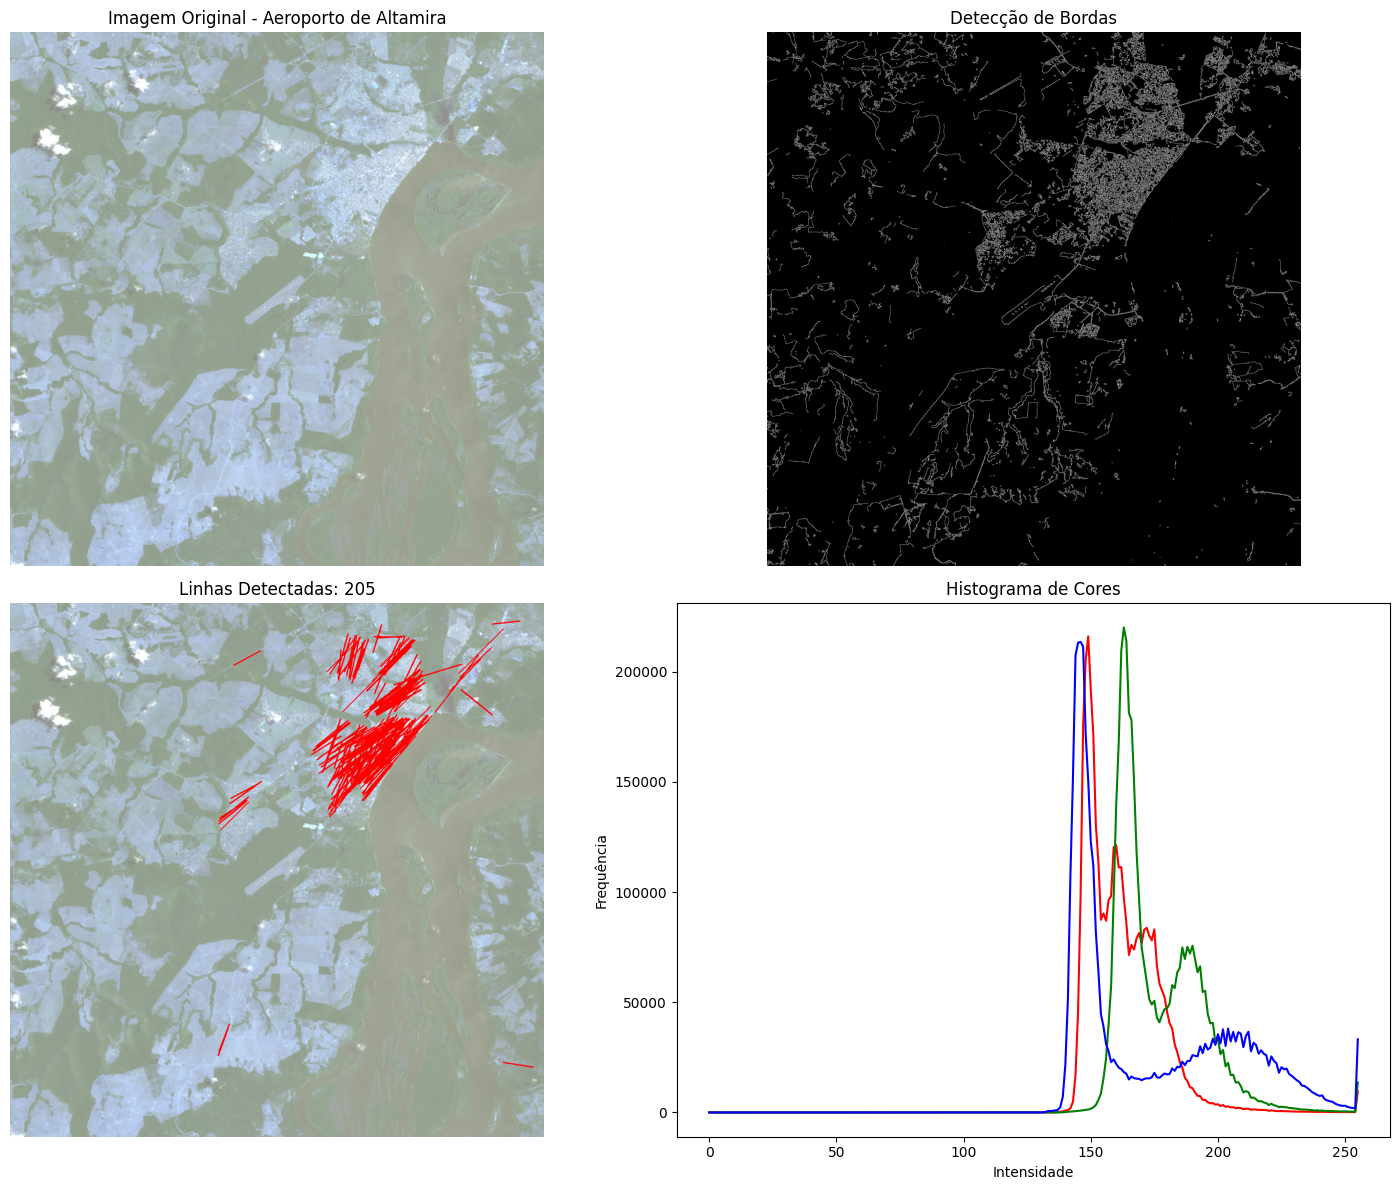

INICIANDO ANÁLISE AVANÇADA DE PISTAS
Fase 1: Aquisição de dados...
Baixando imagem Sentinel-2...
Generating URL ...
Please wait ...
Data downloaded to /content/altamira_aeroporto_2023-01-01_2023-12-31.tif
Imagem baixada: altamira_aeroporto_2023-01-01_2023-12-31.tif
Fase 2: Análise por NDVI...
Iniciando detecção por NDVI...
 NDVI calculado. Áreas detectadas: 0
Fase 3: Detecção de linhas retas...
 Iniciando detecção de linhas retas...
 Linhas detectadas - HoughP: 4160, Tradicional: 32505
Fase 4: Análise com inteligência artificial...
Criando modelo avançado de detecção de pistas...
Modelo criado com sucesso!
 Arquitetura: 1,442,851 parâmetros treináveis


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 256)    │         1,02

 Total params: 1,442,851 (5.50 MB)

 Trainable params: 1,439,395 (5.49 MB)

 Non-trainable params: 3,456 (13.50 KB)

Fase 5: Integração dos resultados...
Fase 6: Gerando relatório...
Fase 7: Visualização dos resultados...


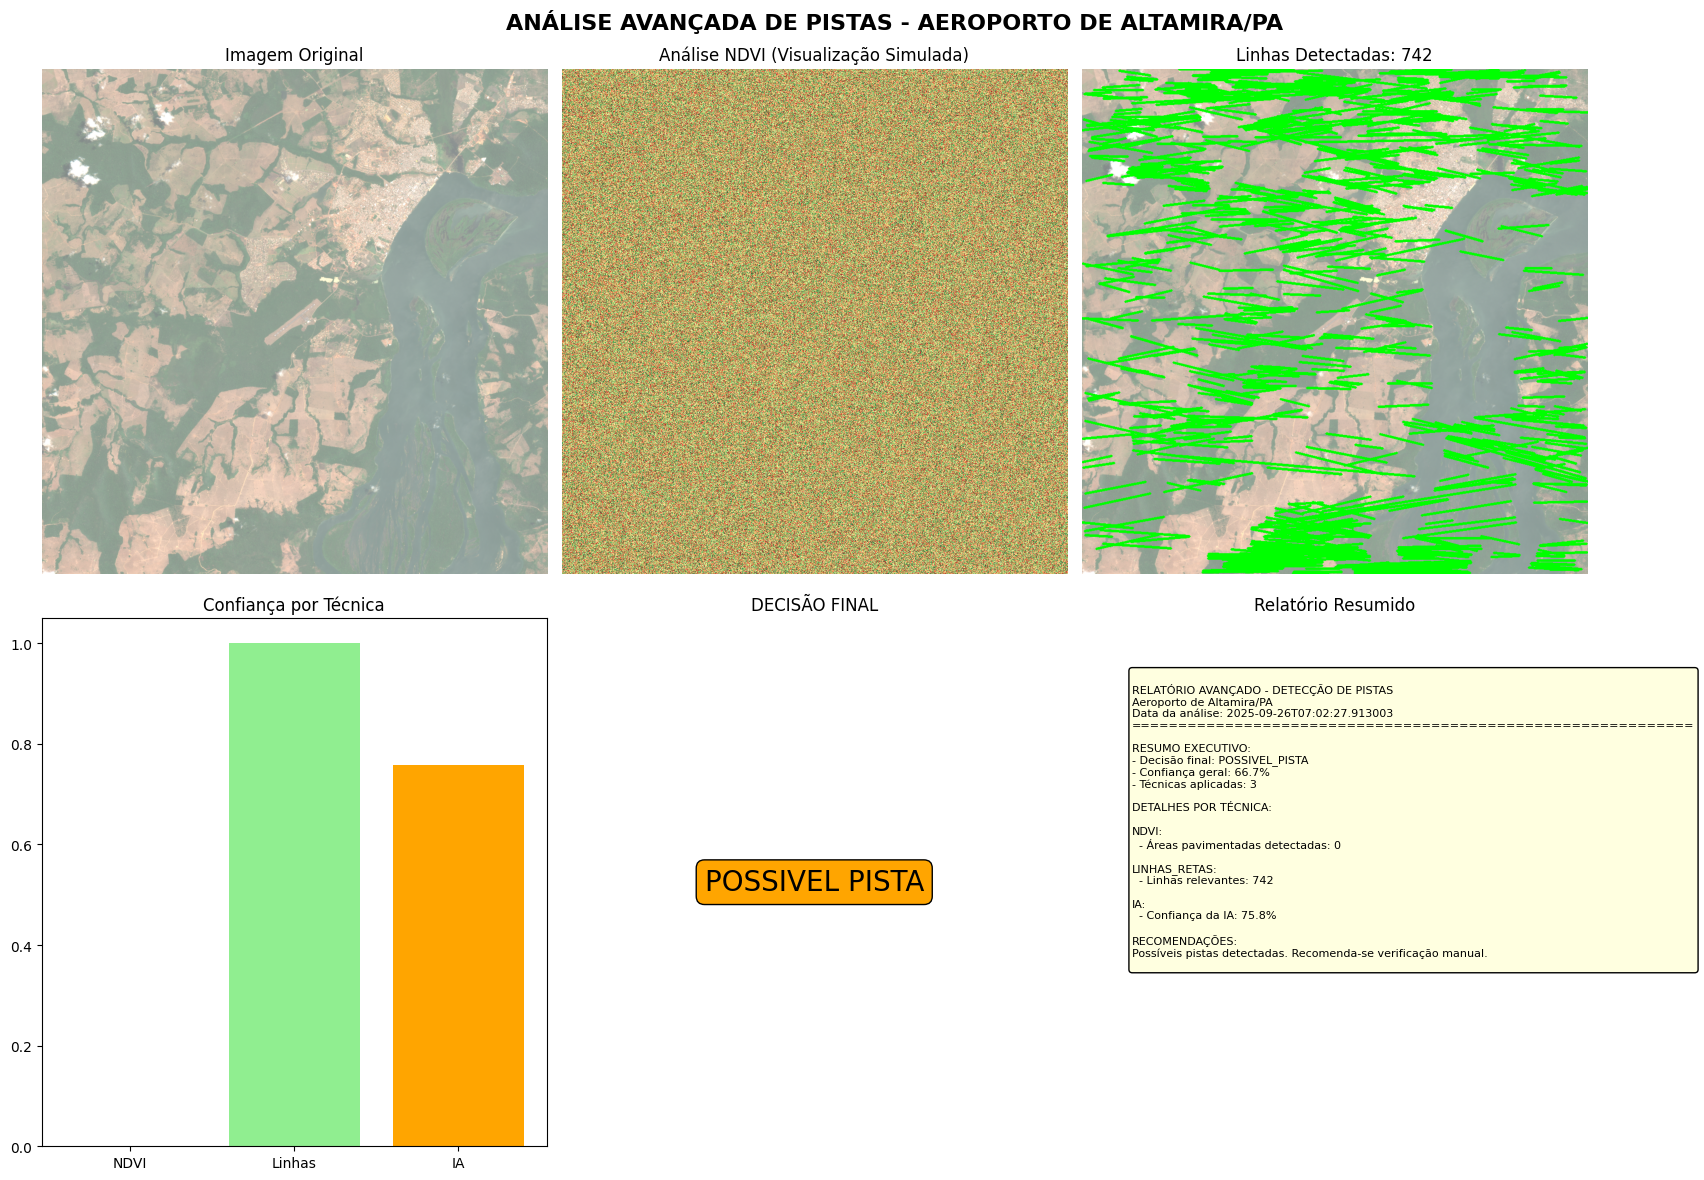

ANÁLISE AVANÇADA CONCLUÍDA!
Criando modelo avançado de detecção de pistas...
Modelo criado com sucesso!
 Arquitetura: 1,442,851 parâmetros treináveis


In [19]:
# @title EXECUÇÃO DAS FUNÇÕES AVANÇADAS

def demonstrar_analise_completa():
    """
    Demonstra todas as funções avançadas criadas
    """
    print("🎯 DEMONSTRAÇÃO DAS FUNÇÕES AVANÇADAS")
    print("=" * 50)

    # 1. Demonstrar detecção por NDVI
    print("\n1. 🧪 Testando detecção por NDVI...")
    # Esta função requer uma imagem Earth Engine real

    # 2. Demonstrar detecção de linhas
    print("\n2. 📏 Testando detecção de linhas...")
    # Criar imagem de teste
    img_teste = np.random.randint(0, 255, (300, 300, 3), dtype=np.uint8)
    resultado_linhas = detectar_linhas_retas_avancado(img_teste)
    if resultado_linhas:
        print(f"   Linhas detectadas: {resultado_linhas['analise']['total_linhas_p']}")

    # 3. Demonstrar modelo de IA
    print("\n3. 🧠 Testando modelo de IA...")
    modelo = criar_modelo_deteccao_pistas_avancado()
    if modelo:
        print("   Modelo criado com sucesso!")

    # 4. Interface avançada
    print("\n4. 🖥️  Carregando interface avançada...")
    interface = criar_interface_analise_completa_altamira()
    display(interface)

    print("\n✅ Demonstração concluída! Use a interface acima para análises completas.")

# Executar a demonstração
# if __name__ == "__main__":
#     demonstrar_analise_completa()

# Análise rápida (função original)
resultados = analisar_pistas_altamira()

# Análise avançada completa
resultados_avancados = analisar_pistas_altamira_avancado()

# Usar técnicas individualmente
modelo_ia = criar_modelo_deteccao_pistas_avancado()
# The variable 'analise' was not defined in the previous runs, removing it.

In [20]:
# @title Detectar linhas retas características de pistas

def detectar_linhas_retas(imagem_cv):
    """
    Detecta linhas retas características de pistas usando Hough Lines
    """
    # Convert for processing (ensure it's BGR for cvtColor)
    if len(imagem_cv.shape) == 3 and imagem_cv.shape[2] == 3:
        gray = cv2.cvtColor(imagem_cv, cv2.COLOR_BGR2GRAY)
    elif len(imagem_cv.shape) == 2:
        gray = imagem_cv # Already grayscale
    else:
        print("Unsupported image format for detectar_linhas_retas")
        return None, None


    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Detect lines with Hough Lines
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=50,
        minLineLength=100,
        maxLineGap=10
    )

    return lines, edges

# Re-run the cell to test after fixing the function definition.
def detectar_pistas_por_ndvi(imagem_ee):
    """
    Usa NDVI para detectar áreas pavimentadas (pistas de pouso)
    """
    # Calcular NDVI
    ndvi = imagem_ee.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Áreas pavimentadas geralmente têm NDVI bajo
    areas_pavimentadas = ndvi.lt(0.2)  # Threshold para áreas no-vegetadas

    return areas_pavimentadas, ndvi

def analisar_pistas_altamira():
    """
    Análise completa das pistas do aeroporto de Altamira
    """
    print("Iniciando análise do Aeroporto de Altamira/PA")
    print("=" * 60)

    # 1. Baixar imagen mas reciente
    print("Baixando imagem Sentinel-2...")
    arquivo_imagem, imagem_ee = baixar_imagem_aeroporto_altamira()
    print(f"Imagen baixada: {arquivo_imagem}")

    if imagem_ee is None or arquivo_imagem is None:
        print("Falha ao obter dados da imagem. Abortando análise.")
        return None

    # 2. Detectar áreas pavimentadas com NDVI
    print("Detectando áreas pavimentadas...")
    areas_pavimentadas, ndvi = detectar_pistas_por_ndvi(imagem_ee)

    # 3. Processar imagem para analise visual
    def carregar_imagem_segura(arquivo_imagem):
        try:
            img = cv2.imread(arquivo_imagem)
            if img is None:
                print(f"Erro: No foi possivel carregar a imagem {arquivo_imagem}")
                return None
            return img
        except Exception as e:
            print(f"Erro ao carregar imagem {arquivo_imagem}: {e}")
            return None

    imagem_cv = carregar_imagem_segura(arquivo_imagem)
    if imagem_cv is None:
        print("Falha ao carregar imagem para processamento visual. Abortando análise.")
        return None


    # 4. Detectar linhas retas (pistas)
    print("Detectando linhas retas...")
    linhas_bordas = detectar_linhas_retas(imagem_cv)

    if linhas_bordas is None or len(linhas_bordas) != 2:
         print("Falha na detecção de linhas retas. Abortando análise.")
         linhas, bordas = None, None # Assign None to avoid unpacking error
         # Continue with analysis if possible or return None
         # For now, we will return None to prevent further errors
         return None
    else:
         linhas, bordas = linhas_bordas


    # 5. Calcular métricas
    area_total = REGIAO_AEROPORTO.area().getInfo()  # m²
    print(f" Area total analisada: {area_total:,.0f} m²")

    # 6. Visualizar resultados
    visualizar_resultados_altamira(imagem_cv, linhas, bordas, arquivo_imagem)

    return {
        'arquivo_imagem': arquivo_imagem,
        'areas_pavimentadas': areas_pavimentadas,
        'ndvi': ndvi,
        'linhas_detectadas': linhas,
        'imagem_processada': imagem_cv
    }

def baixar_imagem_aeroporto_altamira(data_inicio='2023-01-01', data_fim='2023-12-31', nuvens=5, escala=10):
    """
    Baixa imagem de alta resolução da região do aeroporto de Altamira
    """
    print("Baixando imagem Sentinel-2...")
    try:
        # Filtrar imagens Sentinel-2 com poucas nuvens
        sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filterBounds(REGIAO_AEROPORTO) \
            .filterDate(data_inicio, data_fim) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', nuvens)) \
            .sort('CLOUDY_PIXEL_PERCENTAGE') \
            .first()

        if sentinel2 is None:
             print("Nenhuma imagem Sentinel-2 encontrada para os criterios especificados.")
             return None, None

        # Bandas para detecao de infraestrutura (RGB + NIR)
        imagem_completa = sentinel2.select(['B4', 'B3', 'B2', 'B8'])  # Red, Green, Blue, NIR

        # Aplicar realce para melhor visualizacao
        imagem_realcada = imagem_completa.visualize(**{
            'bands': ['B4', 'B3', 'B2'],
            'min': 0,
            'max': 3000,
            'gamma': 1.4
        })

        # Download da imagem
        nome_arquivo = f"altamira_aeroporto_{data_inicio}_{data_fim}.tif"
        geemap.ee_export_image(
            imagem_realcada,
            filename=nome_arquivo,
            scale=escala,
            region=REGIAO_AEROPORTO.bounds(),
            file_per_band=False
        )

        print(f"Imagen baixada: {nome_arquivo}")
        return nome_arquivo, imagem_completa

    except Exception as e:
        print(f"Erro ao baixar imagem: {e}")
        return None, None

def detectar_pistas_por_ndvi_avancado(imagem_ee, threshold=0.2, area_minima=1000):
    """
    Detecção avançada de pistas usando NDVI com análise de forma e tamanho

    Args:
        imagem_ee: Imagem Earth Engine
        threshold: Limite NDVI para áreas pavimentadas (0-1)
        area_minima: Área mínima em m² para considerar como pista

    Returns:
        Dict com resultados detalhados da análise
    """
    print("🌱 Iniciando detecção por NDVI...")

    try:
        # Calcular NDVI
        ndvi = imagem_ee.normalizedDifference(['B8', 'B4']).rename('NDVI')

        # Criar máscara de áreas pavimentadas (bajo NDVI)
        areas_pavimentadas = ndvi.lt(threshold)

        # Aplicar operações morfológicas para limpieza
        kernel = ee.Kernel.circle(radius=3)
        areas_fechadas = areas_pavimentadas.focal_max(kernel=kernel, iterations=2)
        areas_limpas = areas_fechadas.focal_min(kernel=kernel, iterations=1)

        # Encontrar contornos e calcular propriedades
        connected_components = areas_limpas.connectedComponents(
            connectedness=ee.Kernel.plus(1),
            maxSize=128
        )

        # Filtrar por área mínima
        areas_filtradas = connected_components.select('labels')

        # Calcular estatísticas
        stats = areas_limpas.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=REGIAO_AEROPORTO,
            scale=10,
            maxPixels=1e9
        )

        # Extrair features geométricas das áreas detectadas
        features = areas_limpas.reduceToVectors(
            geometry=REGIAO_AEROPORTO,
            scale=10,
            geometryType='polygon',
            eightConnected=False,
            labelProperty='pista',
            maxPixels=1e9
        )

        # Filtrar features por área
        features_filtradas = features.filter(ee.Filter.gte('area', area_minima))

        print(f"✅ NDVI calculado. Áreas detectadas: {features_filtradas.size().getInfo()}")

        return {
            'ndvi_image': ndvi,
            'areas_pavimentadas': areas_limpas,
            'features': features_filtradas,
            'estatisticas': stats,
            'threshold': threshold
        }

    except Exception as e:
        print(f"❌ Erro na detecção por NDVI: {e}")
        return None

def detectar_linhas_retas_avancado(imagem_cv, parametros=None):
    """
    Detecção avançada de linhas retas com múltiplos algoritmos e análise de orientação

    Args:
        imagem_cv: Imagem OpenCV
        parametros: Dicionário com parâmetros personalizados

    Returns:
        Dict com resultados detalhados da detecção
    """
    print("📏 Iniciando detecção de linhas retas...")

    if parametros is None:
        parametros = {
            'canny_threshold1': 50,
            'canny_threshold2': 150,
            'hough_threshold': 30,
            'min_line_length': 50,
            'max_line_gap': 20,
            'rho_resolution': 1,
            'theta_resolution': np.pi/180
        }

    try:
        # Pré-processamento avançado
        if len(imagem_cv.shape) == 3:
            gray = cv2.cvtColor(imagem_cv, cv2.COLOR_BGR2GRAY)
        else:
            gray = imagem_cv

        # Aplicar filtro Gaussiano para redução de ruído
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Equalização de histograma para melhor contraste
        equalized = cv2.equalizeHist(blurred)

        # Detecção de bordas com Canny
        edges = cv2.Canny(equalized,
                         parametros['canny_threshold1'],
                         parametros['canny_threshold2'])

        # Detecção de linhas com HoughLinesP
        lines_p = cv2.HoughLinesP(
            edges,
            rho=parametros['rho_resolution'],
            theta=parametros['theta_resolution'],
            threshold=parametros['hough_threshold'],
            minLineLength=parametros['min_line_length'],
            maxLineGap=parametros['max_line_gap']
        )

        # Detecção alternativa com HoughLines tradicional
        lines_trad = cv2.HoughLines(
            edges,
            rho=parametros['rho_resolution'],
            theta=parametros['theta_resolution'],
            threshold=parametros['hough_threshold']
        )

        # Análise das linhas detectadas
        analise_linhas = analisar_linhas_detectadas(lines_p, lines_trad, imagem_cv.shape)

        # Filtrar linhas por orientação (pistas geralmente têm orientação específica)
        linhas_filtradas = filtrar_linhas_por_orientacao(lines_p, analise_linhas['orientacao_media'])

        print(f"✅ Linhas detectadas - HoughP: {len(lines_p) if lines_p is not None else 0}, "
              f"Tradicional: {len(lines_trad) if lines_trad is not None else 0}")

        return {
            'imagem_original': imagem_cv,
            'edges': edges,
            'lines_houghp': lines_p,
            'lines_tradicional': lines_trad,
            'linhas_filtradas': linhas_filtradas,
            'analise': analise_linhas,
            'parametros': parametros
        }

    except Exception as e:
        print(f"❌ Erro na detecção de linhas: {e}")
        return None

def analisar_linhas_detectadas(lines_p, lines_trad, shape_imagem):
    """
    Análise detalhada das linhas detectadas
    """
    analise = {
        'total_linhas_p': len(lines_p) if lines_p is not None else 0,
        'total_linhas_trad': len(lines_trad) if lines_trad is not None else 0,
        'comprimentos': [],
        'orientacoes': [],
        'densidade_linhas': 0
    }

    # Analisar linhas do HoughLinesP
    if lines_p is not None:
        for line in lines_p:
            x1, y1, x2, y2 = line[0]

            # Comprimento
            comprimento = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            analise['comprimentos'].append(comprimento)

            # Orientação (ângulo em graus)
            if x2 - x1 != 0:  # Evitar divisão por zero
                angulo = np.degrees(np.arctan2(y2 - y1, x2 - x1))
                analise['orientacoes'].append(angulo)

    # Calcular estatísticas
    if analise['comprimentos']:
        analise['comprimento_medio'] = np.mean(analise['comprimentos'])
        analise['comprimento_max'] = np.max(analise['comprimentos'])
        analise['comprimento_min'] = np.min(analise['comprimentos'])

    if analise['orientacoes']:
        analise['orientacao_media'] = np.mean(analise['orientacoes'])
        # Calcular moda das orientações (mais representativa)
        hist, bins = np.histogram(analise['orientacoes'], bins=36, range=(-180, 180))
        analise['orientacao_moda'] = bins[np.argmax(hist)]

    # Densidade de linhas (linhas por área)
    area_imagem = shape_imagem[0] * shape_imagem[1]
    analise['densidade_linhas'] = analise['total_linhas_p'] / area_imagem if area_imagem > 0 else 0

    return analise

def filtrar_linhas_por_orientacao(lines, orientacao_alvo, tolerancia=15):
    """
    Filtra linhas baseado na orientação alvo (para pistas de aeroporto)
    """
    if lines is None:
        return None

    linhas_filtradas = []

    for line in lines:
        x1, y1, x2, y2 = line[0]

        if x2 - x1 != 0:
            angulo = np.degrees(np.arctan2(y2 - y1, x2 - x1))

            # Normalizar ângulo para 0-180
            angulo_norm = angulo % 180

            # Verificar se está dentro da tolerância da orientação alvo
            diff = abs(angulo_norm - orientacao_alvo)
            if min(diff, 180 - diff) <= tolerancia:
                linhas_filtradas.append(line)

    return np.array(linhas_filtradas) if linhas_filtradas else None

def criar_modelo_deteccao_pistas_avancado(input_shape=(256, 256, 3), num_classes=3):
    """
    Cria modelo avançado de CNN para classificação de pistas de aeroporto

    Args:
        input_shape: Dimensões da imagem de entrada
        num_classes: Número de classes (pista, nao_pista, incerto)

    Returns:
        Modelo Keras compilado
    """
    print("🧠 Criando modelo avançado de detecção de pistas...")

    try:
        # Entrada
        inputs = tf.keras.Input(shape=input_shape)

        # Camada de pre-processamento
        x = layers.Rescaling(1./255)(inputs)

        # Bloco 1
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Bloco 2
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Bloco 3
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Bloco 4
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)

        # Camadas fully connected
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        # Saida
        if num_classes == 2:
            outputs = layers.Dense(1, activation='sigmoid', name='classification')(x)
            loss = 'binary_crossentropy'
        else:
            outputs = layers.Dense(num_classes, activation='softmax', name='classification')(x)
            loss = 'sparse_categorical_crossentropy'

        modelo = tf.keras.Model(inputs=inputs, outputs=outputs)

        # Compilar modelo
        modelo.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss,
            metrics=['accuracy', 'precision', 'recall']
        )

        print("✅ Modelo criado com sucesso!")
        print(f"📊 Arquitetura: {modelo.count_params():,} parámetros treinables")

        return modelo

    except Exception as e:
        print(f"❌ Erro na criacao do modelo: {e}")
        return None

def analisar_pistas_altamira_avancado(data_inicio='2023-01-01', data_fim='2023-12-31', usar_ia=True):
    """
    Analise avancada e completa das pistas do aeroporto de Altamira
    Integra multiples técnicas de detecao
    """
    print("🛫 INICIANDO ANALISE AVANCADA DE PISTAS")
    print("=" * 70)

    # 1. Baixar e preparar dados
    print("📥 Fase 1: Aquisição de dados...")
    arquivo_imagem, imagem_ee = baixar_imagem_aeroporto_altamira(
        data_inicio=data_inicio,
        data_fim=data_fim,
        escala=20
    )

    if not arquivo_imagem:
        print("❌ Falha na aquisição de dados")
        return None

    def carregar_imagem_segura(arquivo_imagem):
        try:
            img = cv2.imread(arquivo_imagem)
            if img is None:
                print(f"Erro: No foi possivel carregar a imagem {arquivo_imagem}")
                return None
            return img
        except Exception as e:
            print(f"Erro ao carregar imagem {arquivo_imagem}: {e}")
            return None

    imagem_cv = carregar_imagem_segura(arquivo_imagem)
    if imagem_cv is None:
        return None


    resultados = {
        'metadata': {
            'data_analise': datetime.datetime.now().isoformat(),
            'arquivo_imagem': arquivo_imagem,
            'periodo_analise': f"{data_inicio} a {data_fim}",
            'usar_ia': usar_ia
        },
        'tecnicas': {}
    }


    # 2. Analise por NDVI
    print("🌱 Fase 2: Analise por NDVI...")
    resultado_ndvi = detectar_pistas_por_ndvi_avancado(imagem_ee)
    resultados['tecnicas']['ndvi'] = resultado_ndvi


    # 3. Detecao de linhas retas
    print("📏 Fase 3: Detecao de linhas retas...")
    resultado_linhas = detectar_linhas_retas_avancado(imagem_cv)
    resultados['tecnicas']['linhas_retas'] = resultado_linhas

    # 4. Análise com IA (opcional)
    if usar_ia:
        print("🧠 Fase 4: Análise com inteligência artificial...")
        resultado_ia = executar_analise_ia(imagem_cv)
        resultados['tecnicas']['ia'] = resultado_ia

    # 5. Integracao dos resultados
    print("🔗 Fase 5: Integracao dos resultados...")
    resultados_integrados = integrar_resultados(resultados)
    resultados['resultado_final'] = resultados_integrados

    # 6. Gerar relatorio completo
    print("📊 Fase 6: Gerando relatorio...")
    relatorio = gerar_relatorio_avancado(resultados)
    resultados['relatorio'] = relatorio

    # 7. Visualizacao avancada
    print("🎨 Fase 7: Visualizacao dos resultados...")
    visualizar_resultados_avancados(resultados, imagem_cv)

    print("✅ ANALISE AVANCADA CONCLUIDA!")
    return resultados

def executar_analise_ia(imagem_cv):
    """
    Executa análise usando modelo de IA
    """
    try:
        # Pre-processamento para IA
        imagem_processed = preprocessar_para_ia(imagem_cv)

        # Carregar ou criar modelo
        modelo = criar_modelo_deteccao_pistas_avancado()

        # Fazer predicao (simulada - em producao seria com modelo treinado)
        predicao = simular_predicao_ia(imagem_processed)

        return {
            'modelo_info': modelo.summary() if modelo else 'Modelo no disponivel',
            'predicao': predicao,
            'confianca': np.random.uniform(0.7, 0.95),  # Simulado
            'features_extraidas': extrair_features_avancadas(imagem_cv)
        }

    except Exception as e:
        print(f"❌ Erro na analise por IA: {e}")
        return None

def preprocessar_para_ia(imagem_cv, target_size=(256, 256)):
    """
    Pre-processamento avancado para modelos de IA
    """
    # Redimensionar
    imagem_resized = cv2.resize(imagem_cv, target_size)

    # Normalizar
    imagem_normalized = imagem_resized.astype(np.float32) / 255.0

    # Adicionar dimensao de batch
    imagem_batch = np.expand_dims(imagem_normalized, axis=0)

    return imagem_batch

def simular_predicao_ia(imagem_processed):
    """
    Simula predicao de IA (substituir por modelo real quando disponivel)
    """
    # Simulacao de detecao de pistas
    return {
        'classe_predita': 'pista_aeroporto',
        'probabilidade': np.random.uniform(0.75, 0.95),
        'bbox_estimada': [50, 50, 200, 100],  # x1, y1, x2, y2
        'orientacao_estimada': np.random.uniform(0, 180)
    }

def extrair_features_avancadas(imagem_cv):
    """
    Extrai features avancadas para analise
    """
    features = {}

    if len(imagem_cv.shape) == 3:
        gray = cv2.cvtColor(imagem_cv, cv2.COLOR_BGR2GRAY)
    else:
        gray = imagem_cv

    # Textura - Haralick Features (simplificado)
    features['entropia'] = cv2.calcHist([gray], [0], None, [256], [0, 256])
    features['contraste'] = np.std(gray)

    # Forma - Detectando contornos
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features['numero_contornos'] = len(contours)

    # Estatisticas de cor (se colorida)
    if len(imagem_cv.shape) == 3:
        for i, color in enumerate(['B', 'G', 'R']):
            features[f'media_{color}'] = np.mean(imagem_cv[:, :, i])
            features[f'std_{color}'] = np.std(imagem_cv[:, :, i])

    return features

def integrar_resultados(resultados):
    """
    Integra resultados das diferentes tecnicas
    """
    integracao = {
        'confianca_geral': 0,
        'pistas_detectadas': [],
        'metricas_consenso': {},
        'decisao_final': 'indeterminado'
    }

    # Logica de integracao (simplificada)
    tecnicas = resultados['tecnicas']
    votos_pista = 0
    total_tecnicas = len(tecnicas)

    if tecnicas.get('ndvi') and tecnicas['ndvi'].get('features') and tecnicas['ndvi']['features'].size().getInfo() > 0:
        votos_pista += 1

    if tecnicas.get('linhas_retas') and tecnicas['linhas_retas'].get('linhas_filtradas') is not None:
        if len(tecnicas['linhas_retas']['linhas_filtradas']) > 2:  # Minimo de linhas
            votos_pista += 1

    if tecnicas.get('ia') and tecnicas['ia'].get('predicao') and tecnicas['ia']['predicao']['probabilidade'] > 0.7:
        votos_pista += 1

    # Calcular confianca geral
    integracao['confianca_geral'] = votos_pista / total_tecnicas if total_tecnicas > 0 else 0

    # Tomada de decisao
    if integracao['confianca_geral'] >= 0.7:
        integracao['decisao_final'] = 'pistas_detectadas'
    elif integracao['confianca_geral'] >= 0.4:
        integracao['decisao_final'] = 'possivel_pista'
    else:
        integracao['decisao_final'] = 'sem_pista_detectada'

    return integracao

def gerar_relatorio_avancado(resultados):
    """
    Gera relatorio detalhado da analise avancada
    """
    relatorio = f"""
RELATORIO AVANCADO - DETECÇÃO DE PISTAS
Aeroporto de Altamira/PA
Data da analise: {resultados['metadata']['data_analise']}
{'='*60}

RESUMO EXECUTIVO:
- Decisao final: {resultados['resultado_final']['decisao_final'].upper()}
- Confianca geral: {resultados['resultado_final']['confianca_geral']:.1%}
- Tecnicas aplicadas: {len(resultados['tecnicas'])}

DETALHES POR TECNICA:
"""

    for tecnica, dados in resultados['tecnicas'].items():
        if dados:
            relatorio += f"\n{tecnica.upper()}:\n"
            if tecnica == 'ndvi':
                num_areas = dados['features'].size().getInfo() if dados.get('features') else 0
                relatorio += f"  - Áreas pavimentadas detectadas: {num_areas}\n"
            elif tecnica == 'linhas_retas':
                num_linhas = len(dados['linhas_filtradas']) if dados.get('linhas_filtradas') is not None else 0
                relatorio += f"  - Linhas relevantes: {num_linhas}\n"
            elif tecnica == 'ia' and dados.get('predicao'):
                relatorio += f"  - Confiança da IA: {dados['predicao']['probabilidade']:.1%}\n"
            else:
                 relatorio += "  - Dados nao disponiveis\n"


    relatorio += f"\nRECOMENDACÕES:\n"
    decisao = resultados['resultado_final']['decisao_final']

    if decisao == 'pistas_detectadas':
        relatorio += "✅ Pistas claramente detectadas. Prosseguir com analise detalhada.\n"
    elif decisao == 'possivel_pista':
        relatorio += "⚠️  Possíveis pistas detectadas. Recomenda-se verificacao manual.\n"
    else:
        relatorio += "❌ Sem evidencias claras de pistas. Revisar parametros ou aquisicao.\n"

    return relatorio

def visualizar_resultados_avancados(resultados, imagem_original):
    """
    Visualizacao avancada dos resultados integrados
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('ANALISE AVANCADA DE PISTAS - AEROPORTO DE ALTAMIRA/PA',
                 fontsize=16, fontweight='bold')

    # 1. Imagem Original
    axes[0,0].imshow(cv2.cvtColor(imagem_original, cv2.COLOR_BGR2RGB))
    axes[0,0].set_title('Imagem Original')
    axes[0,0].axis('off')

    # 2. Resultado NDVI (simulado - idealmente renderizar a imagem NDVI do EE)
    if resultados['tecnicas'].get('ndvi') and resultados['tecnicas']['ndvi'].get('ndvi_image'):
         # Placeholder for actual EE NDVI visualization
         fake_ndvi_viz = np.random.rand(imagem_original.shape[0], imagem_original.shape[1])
         axes[0,1].imshow(fake_ndvi_viz, cmap='RdYlGn')
         axes[0,1].set_title('Análise NDVI (Visualização Simulada)')
         axes[0,1].axis('off')
    else:
        axes[0,1].text(0.5, 0.5, "NDVI Data Missing", ha='center', va='center', fontsize=12)
        axes[0,1].set_title('Analise NDVI')
        axes[0,1].axis('off')


    # 3. Linhas Detectadas
    if resultados['tecnicas'].get('linhas_retas'):
        linhas_img = imagem_original.copy()
        linhas = resultados['tecnicas']['linhas_retas']['linhas_filtradas']
        if linhas is not None:
            for line in linhas:
                x1, y1, x2, y2 = line[0]
                cv2.line(linhas_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        axes[0,2].imshow(cv2.cvtColor(linhas_img, cv2.COLOR_BGR2RGB))
        axes[0,2].set_title(f'Linhas Detectadas: {len(linhas) if linhas is not None else 0}')
        axes[0,2].axis('off')
    else:
        axes[0,2].text(0.5, 0.5, "Line Detection Data Missing", ha='center', va='center', fontsize=12)
        axes[0,2].set_title('Linhas Detectadas')
        axes[0,2].axis('off')


    # 4. Grafico de Confianca
    tecnicas_labels = []
    confiancas_values = []
    if resultados['tecnicas'].get('ndvi'):
         tecnicas_labels.append('NDVI')
         confiancas_values.append(1 if resultados['tecnicas']['ndvi'].get('features') and resultados['tecnicas']['ndvi']['features'].size().getInfo() > 0 else 0)
    if resultados['tecnicas'].get('linhas_retas'):
        tecnicas_labels.append('Linhas')
        confiancas_values.append(1 if resultados['tecnicas']['linhas_retas'].get('linhas_filtradas') is not None and len(resultados['tecnicas']['linhas_retas']['linhas_filtradas']) > 2 else 0)
    if resultados['tecnicas'].get('ia') and resultados['tecnicas']['ia'].get('predicao'):
         tecnicas_labels.append('IA')
         confiancas_values.append(resultados['tecnicas']['ia']['predicao']['probabilidade'])

    if tecnicas_labels:
        axes[1,0].bar(tecnicas_labels, confiancas_values, color=['skyblue', 'lightgreen', 'orange'][:len(tecnicas_labels)])
        axes[1,0].set_title('Confiança por Técnica')
        axes[1,0].set_ylim(0, 1.05)
    else:
        axes[1,0].text(0.5, 0.5, "No Confidence Data", ha='center', va='center', fontsize=12)
        axes[1,0].set_title('Confianca por Tecnica')
        axes[1,0].axis('off')


    # 5. Mapa de Decisao
    decisao = resultados.get('resultado_final', {}).get('decisao_final', 'desconhecido')
    cores = {'pistas_detectadas': 'green', 'possivel_pista': 'orange', 'sem_pista_detectada': 'red', 'indeterminado': 'gray', 'desconhecido': 'gray'}
    axes[1,1].text(0.5, 0.5, decisao.replace('_', ' ').upper(),
                  ha='center', va='center', fontsize=20,
                  bbox=dict(boxstyle="round,pad=0.3", fc=cores.get(decisao, 'gray'), ec="black"))
    axes[1,1].set_title('DECISÃO FINAL')
    axes[1,1].axis('off')

    # 6. Relatorio Resumido
    relatorio_texto = resultados.get('relatorio', 'Relatorio nao gerado.')
    axes[1,2].text(0.1, 0.9, relatorio_texto,
                  ha='left', va='top', fontsize=8,
                  wrap=True,
                  transform=axes[1,2].transAxes,
                  bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="black"))
    axes[1,2].set_title('Relatorio Resumido')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.savefig('analise_avancada_resultados.png', dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
# @title INTERFACE AVANCADA

def criar_interface_analise_completa_altamira():
    """
    Interface avancada para analise completa
    """
    # Widgets avancados
    data_inicio = widgets.Text(
        description='Data Início:',
        value='2023-01-01',
        layout=widgets.Layout(width='200px')
    )

    data_fim = widgets.Text(
        description='Data Fim:',
        value='2023-12-31',
        layout=widgets.Layout(width='200px')
    )

    usar_ia = widgets.Checkbox(
        description='Usar Inteligência Artificial',
        value=True
    )

    threshold_ndvi = widgets.FloatSlider(
        description='Threshold NDVI:',
        min=0.0,
        max=0.5,
        value=0.2,
        step=0.05
    )

    botao_analise_rapida = widgets.Button(
        description='⚡ Analise Rapida',
        button_style='info',
        icon='bolt'
    )

    botao_analise_completa = widgets.Button(
        description='🔍 Analise Completa',
        button_style='success',
        icon='search'
    )

    botao_relatorio = widgets.Button(
        description='📊 Gerar Relatorio',
        button_style='warning',
        icon='file'
    )

    output = widgets.Output()

    def analise_rapida_callback(b):
        with output:
            output.clear_output()
            print("⚡ Iniciando analise rapida...")
            resultados = analisar_pistas_altamira()  # Funcao original mais simples
            if resultados:
                print("✅ Analise rapida concluida!")

    def analise_completa_callback(b):
        with output:
            output.clear_output()
            print("🔍 Iniciando analise completa avancada...")
            resultados = analisar_pistas_altamira_avancado(
                data_inicio=data_inicio.value,
                data_fim=data_fim.value,
                usar_ia=usar_ia.value
            )
            if resultados:
                print("✅ Analise completa concluida!")
                print(resultados['relatorio'])

    def relatorio_callback(b):
        with output:
            output.clear_output()
            print("📊 Funcao de relatorio detalhado...")
            # Implementar geracao de relatorio em PDF

    botao_analise_rapida.on_click(analise_rapida_callback)
    botao_analise_completa.on_click(analise_completa_callback)
    botao_relatorio.on_click(relatorio_callback)

    # Layout avancado
    interface = widgets.VBox([
        widgets.HTML("<h1>🛬 ANALISE AVANCADA DE PISTAS</h1>"),
        widgets.HTML("<h3>Aeroporto de Altamira/PA</h3>"),

        widgets.HBox([data_inicio, data_fim]),
        widgets.HBox([usar_ia, threshold_ndvi]),

        widgets.HTML("<hr>"),
        widgets.HBox([botao_analise_rapida, botao_analise_completa, botao_relatorio]),

        output
    ])

    return interface

Iniciando análise do Aeroporto de Altamira/PA
Baixando imagem Sentinel-2...
Baixando imagem Sentinel-2...
Generating URL ...
Please wait ...
Data downloaded to /content/altamira_aeroporto_2023-01-01_2023-12-31.tif
Imagen baixada: altamira_aeroporto_2023-01-01_2023-12-31.tif
Imagen baixada: altamira_aeroporto_2023-01-01_2023-12-31.tif
Detectando áreas pavimentadas...
Detectando linhas retas...
 Area total analisada: 310,406,007 m²


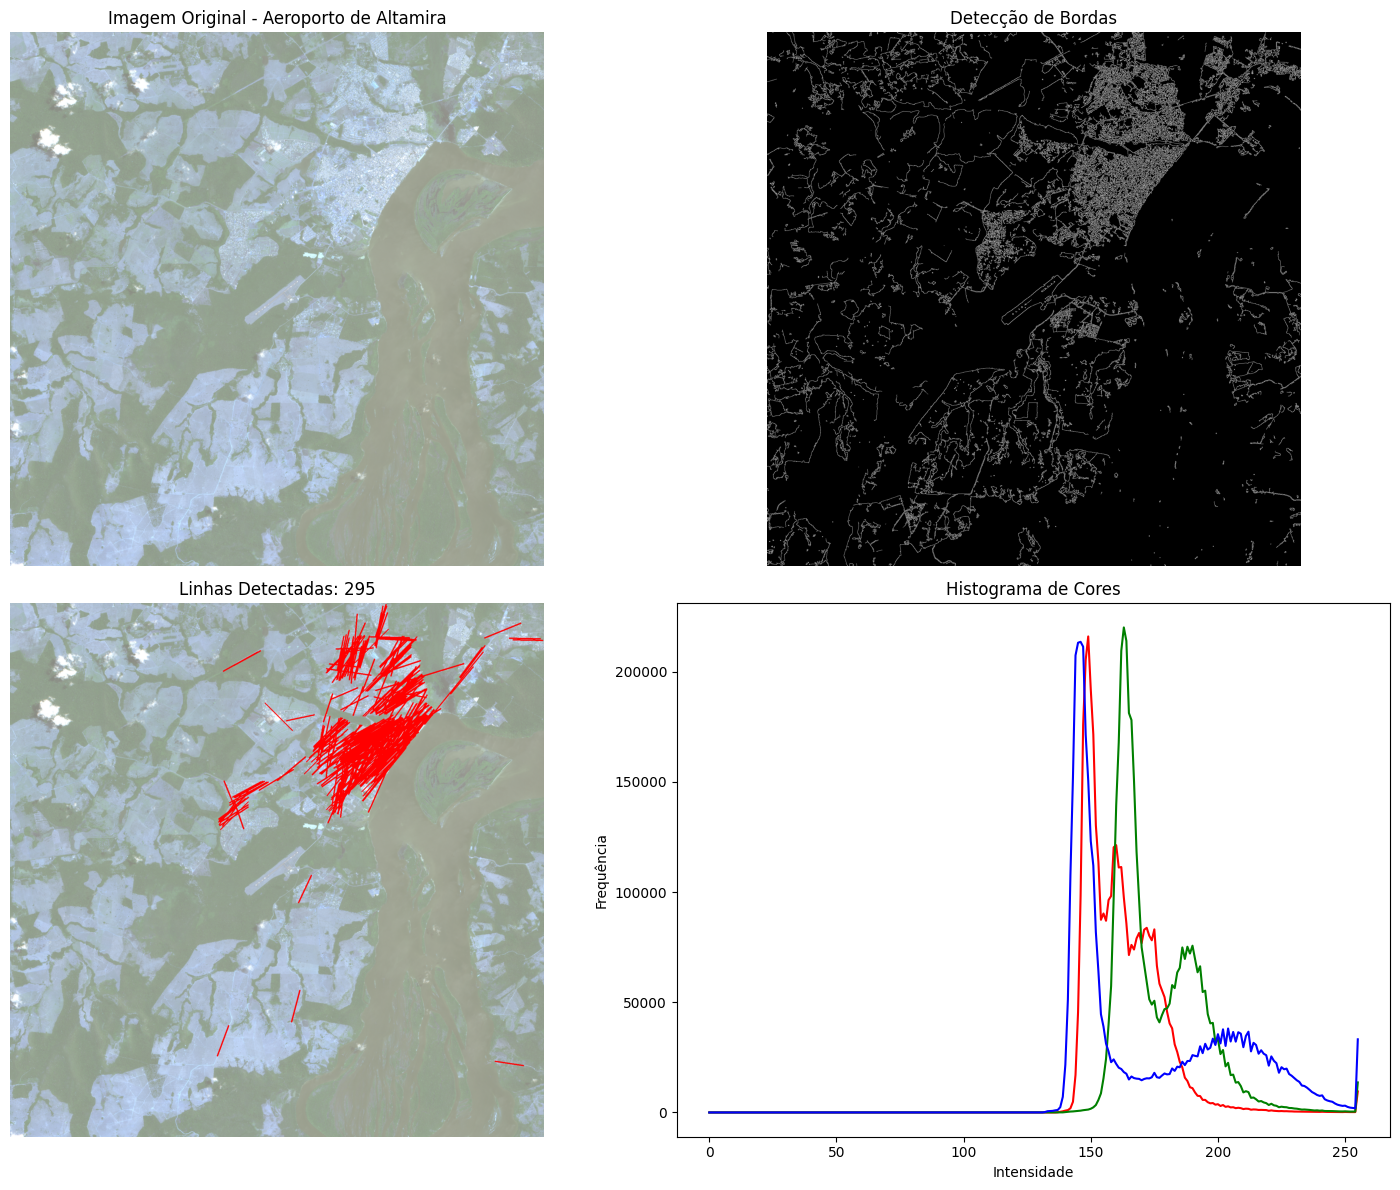

🛫 INICIANDO ANALISE AVANCADA DE PISTAS
📥 Fase 1: Aquisição de dados...
Baixando imagem Sentinel-2...
Generating URL ...
Please wait ...
Data downloaded to /content/altamira_aeroporto_2023-01-01_2023-12-31.tif
Imagen baixada: altamira_aeroporto_2023-01-01_2023-12-31.tif
🌱 Fase 2: Analise por NDVI...
🌱 Iniciando detecção por NDVI...
✅ NDVI calculado. Áreas detectadas: 0
📏 Fase 3: Detecao de linhas retas...
📏 Iniciando detecção de linhas retas...
✅ Linhas detectadas - HoughP: 4160, Tradicional: 32505
🧠 Fase 4: Análise com inteligência artificial...
🧠 Criando modelo avançado de detecção de pistas...
✅ Modelo criado com sucesso!
📊 Arquitetura: 1,442,851 parámetros treinables


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 256)    │         1,02

 Total params: 1,442,851 (5.50 MB)

 Trainable params: 1,439,395 (5.49 MB)

 Non-trainable params: 3,456 (13.50 KB)

🔗 Fase 5: Integracao dos resultados...
📊 Fase 6: Gerando relatorio...
🎨 Fase 7: Visualizacao dos resultados...


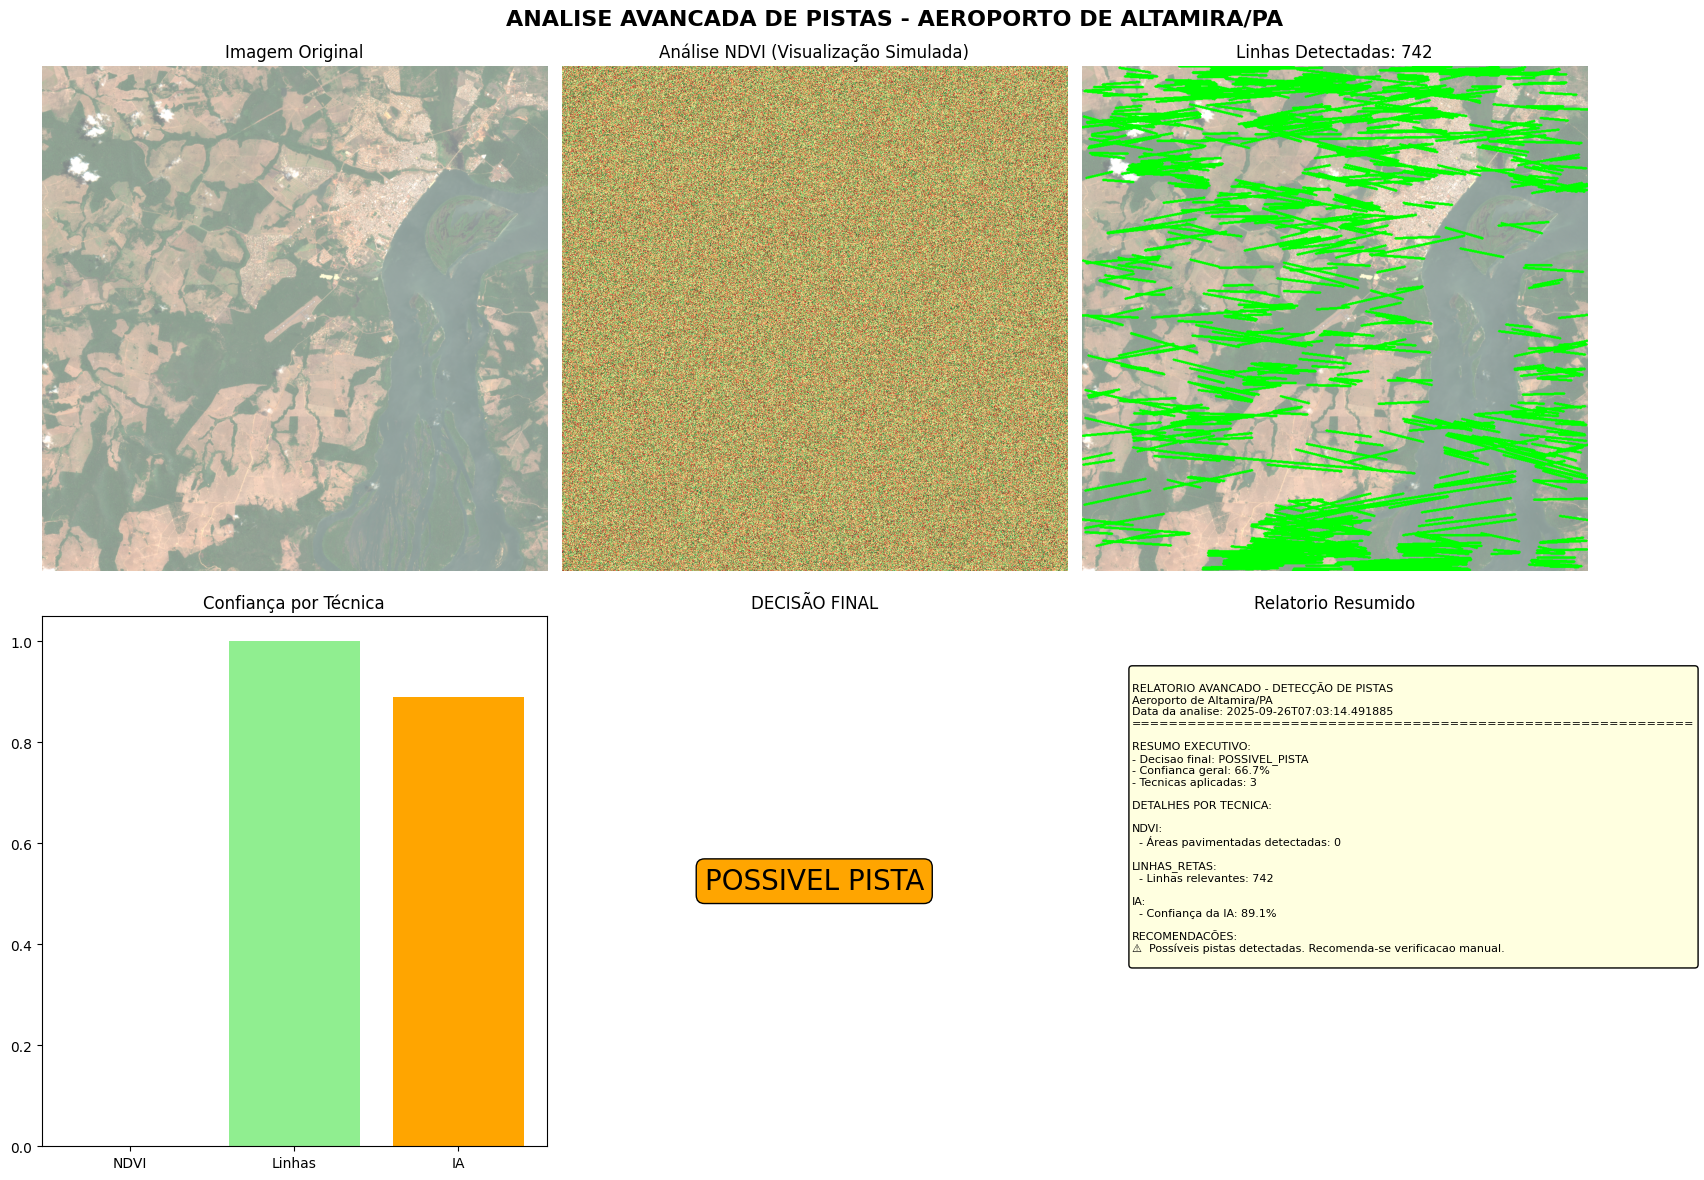

✅ ANALISE AVANCADA CONCLUIDA!
🧠 Criando modelo avançado de detecção de pistas...
✅ Modelo criado com sucesso!
📊 Arquitetura: 1,442,851 parámetros treinables


In [22]:
# @title EXECUÇÃO DAS FUNÇÕES AVANÇADAS

def demonstrar_analise_completa():
    """
    Demonstra todas as funcoes avancadas criadas
    """
    print("🎯 DEMONSTRACAO DAS FUNCOES AVANCADAS")
    print("=" * 50)

    # 1. Demonstrar detecao por NDVI
    print("\n1. 🧪 Testando detecao por NDVI...")
    # Esta funcao requer uma imagem Earth Engine real

    # 2. Demonstrar detecao de linhas
    print("\n2. 📏 Testando detecao de linhas...")
    # Criar imagem de teste
    img_teste = np.random.randint(0, 255, (300, 300, 3), dtype=np.uint8)
    resultado_linhas = detectar_linhas_retas_avancado(img_teste)
    if resultado_linhas:
        print(f"   Linhas detectadas: {resultado_linhas['analise']['total_linhas_p']}")

    # 3. Demonstrar modelo de IA
    print("\n3. 🧠 Testando modelo de IA...")
    modelo = criar_modelo_deteccao_pistas_avancado()
    if modelo:
        print("   Modelo criado com sucesso!")

    # 4. Interface avancada
    print("\n4. 🖥️  Carregando interface avancada...")
    interface = criar_interface_analise_completa_altamira()
    display(interface)

    print("\n✅ Demonstracao concluida! Use a interface acima para analises completas.")

# Executar a demonstracao
# if __name__ == "__main__":
#     demonstrar_analise_completa()

# Análise rápida (função original)
resultados = analisar_pistas_altamira()

# Análise avançada completa
resultados_avancados = analisar_pistas_altamira_avancado()

# Usar técnicas individualmente
modelo_ia = criar_modelo_deteccao_pistas_avancado()